In [1]:
#import important modules
import pymongo as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from pymongo import MongoClient
import json
import pickle
import re
import pprint
import datetime
import statistics as st

In [2]:
with open('editeddata/conversations.json', 'r') as convo_json:
    convos = json.load(convo_json)

In [3]:
client = MongoClient('localhost', 27017)
mydb = client.tweets
col = mydb['_tweets']

In [4]:
airlines = {'KLM':56377143, 
            'AirFrance': 106062176, 
            'British_Airways': 18332190, 
            'AmericanAir': 22536055, 
           'Lufthansa': 124476322, 
           'AirBerlin': 26223583, 
           'AirBerlinAssist': 2182373406, 
           'easyJet': 38676903, 
           'RyanAir': 1542862735, 
           'SingaporeAir': 253340062, 
           'Qantas': 218730857, 
           'EtihadAirways': 45621423, 
           'VirginAtlantic': 20626359}

In [5]:
air_count = pickle.load(open("save.p", "rb"))

Get the ratio of replied tweets for every airline

In [6]:
for name in airlines:
    if len(air_count[name]['ids']) != 0:
        conv_tweets = len(air_count[name]['ids']) - len(list(col.find({'user.id': airlines[name], 'in_reply_to_user_id':'none'})))
        a = len(list(col.find({'user.id' : airlines[name], 'in_reply_to_user_id' :{'$ne': 'none'}})))
        air_count[name]['rep_to_all'] = a / conv_tweets
        if a != 0:
            air_count[name]['rec_to_rep'] = (conv_tweets - a) / a 
        else:
            air_count[name]['rec_to_rep'] = conv_tweets
    else:
        air_count[name]['rep_to_all'] = 0
        air_count[name]['rec_to_rep'] = 0

Received over reply tweets. 
We exclude AirBerlin (which didn't reply at all to its cutomers) and AirBerlinAssist (which doesn't have any tweets associated with them)

In [21]:
reps = pd.DataFrame(columns=['airline', 'rec_to_rep_ratio'])
reps['airline'] = [i for i in airlines.keys() if i not in 'AirBerlinAssist']
reps['rec_to_rep_ratio'] = [air_count[name]['rec_to_rep'] for name in airlines if name not in 'AirBerlinAssist']
reps_sort = reps.sort_values(by='rec_to_rep_ratio', ascending=False)
reps_sort = reps_sort.reset_index(drop=True)
reps_sort

,airline,rec_to_rep_ratio
0,EtihadAirways,41.679287
1,Qantas,16.264645
2,AmericanAir,14.689286
3,Lufthansa,9.579556
4,KLM,6.780810
5,RyanAir,4.331509
6,AirFrance,3.796608
7,easyJet,3.737165
8,VirginAtlantic,3.497543
9,British_Airways,3.039093


The point is to be low on the table as that indicates a low number of received tweets per a reply

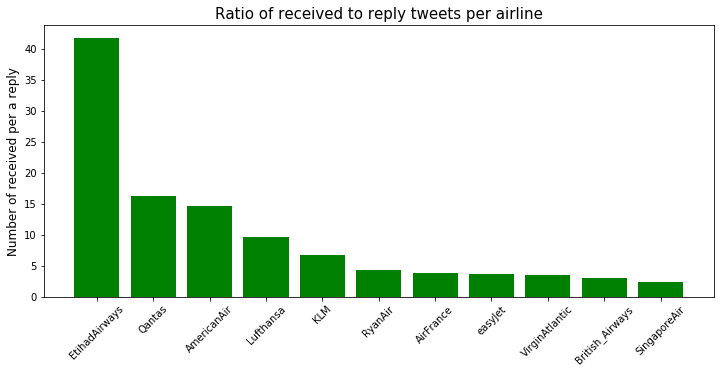

In [13]:
plt.figure(figsize=(12,5))
plt.bar(reps_sort['airline'], reps_sort['rec_to_rep_ratio'], color='green')
plt.xticks(rotation='45')
plt.title('Ratio of received to reply tweets per airline', size=15)
plt.ylabel('Number of received per a reply', size=12);

In [26]:
print('SingaporeAir:', air_count['SingaporeAir']['rec_to_rep'], '\n', 'KLM:', air_count['KLM']['rec_to_rep'], '\n' 'Mean:', st.mean(list(reps['rec_to_rep_ratio'])))


SingaporeAir: 2.4514672686230248 
 KLM: 6.780810038767599 
Mean: 9.986088144227395


In [52]:
rep_ratios = pd.DataFrame(columns=['airline', 'rep_to_all'])
rep_ratios['airline'] = [i for i in airlines.keys()]
rep_ratios['rep_to_all'] = [air_count[name]['rep_to_all'] for name in airlines.keys()]
rep_ratios_sort = rep_ratios.sort_values(by='rep_to_all', ascending=False)
rep_ratios_sort

,airline,rep_to_all
9,SingaporeAir,0.289732
2,British_Airways,0.247580
12,VirginAtlantic,0.222344
7,easyJet,0.211097
1,AirFrance,0.208481
8,RyanAir,0.187564
0,KLM,0.128521
4,Lufthansa,0.094522
3,AmericanAir,0.063738
10,Qantas,0.057922


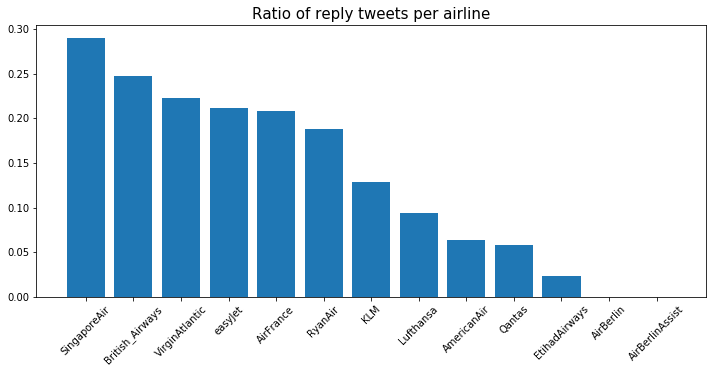

In [53]:
plt.figure(figsize=(12,5))
plt.bar(rep_ratios_sort['airline'], rep_ratios_sort['rep_to_all'])
plt.xticks(rotation='45')
plt.title('Ratio of reply tweets per airline', size=15);

Replies over all tweets

In [54]:
print('KLM:', air_count['KLM']['rep_to_all'], '\n', 'Mean:',  st.mean(list(rep_ratios['rep_to_all'])))


KLM: 0.12852132297505492 
 Mean: 0.13345621304626304


Number of tweets received from users normalized on the number of followers -> THIS WON'T BE INCLUDED

In [55]:
for name in airlines:
    if name != 'AirBerlin' and name != 'AirBerlinAssist':
        air_count[name]['followers'] = col.find_one({'user.id': airlines[name]})['user']['followers_count']
        air_count[name]['norm_tweets'] = (air_count[name]['nr']*(1-air_count[name]['rep_ratio']))/air_count[name]['followers']
    else:
        air_count[name]['followers'] = 'unknown'
        air_count[name]['norm_tweets'] = 'unknown'

Note: AirBerlin and AirBerlinAssist are not included since we don't have any tweets from them, hence no information on the number of followers.

In [56]:
for name in airlines:
    print(air_count[name]['norm_tweets'])

0.05690315278679093
0.08737490829053558
0.16499212861505594
0.17534325455220157
0.19193193521205879
unknown
unknown
0.2859667462095734
0.09204724116437656
0.029041847058094955
0.18126486170789705
0.028696688242086328
0.08238347374735909


We get the ratio of tweets customers post to the number of followers a company has.
This is problematic since we are not sure the people who tweeted about an airline are actually their followers.

1136902244366864400
1136902963518222300
1136904349240713200
1136905533674459100
1136905710074306600
1136906003994349600
1136917771709747200
1136906773993021400
1136906811678908400
1136907049273569300
1136907603232141300
1136917800990183400
1136918750257713200
1136919285815763000
1136919348961001500
1136938233961599000
1136938246129246200
1136938690058625000
1136941308038266900
1136940827597529100
1136967516289491000
1136947676434575400
1136948400358862800
1136951205463253000
1136969390853898200
1136969412035194900
1136969525268766700
1136969858506268700
1136969970896822300
1136970454277775400
1136970042082545700
1136976098686832600
1136976609020448800
1136977919769813000
1136978200075165700
1136978219637325800
1136993752403365900
1136994243430486000
1136994510733480000
1136995331067994100
1137001216590995500
1136995704390529000
1136995705896259600
1136996078505648100
1136996248802734100
1137001728283500500
1137001857161867300
1137002190474752000
1137002200599863300
1137003031243972600


1159245313120620500
1159227413521264600
1159247038015582200
1159247484125950000
1214501976676941800
1159273392782106600
1159247877757132800
1159270433918804000
1159275739251925000
1159303054031806500
1159304320799707100
1159304816578842600
1159305708137066500
1159305827012030500
1159306399609790500
1159307552993230800
1159307869893922800
1159307937493340200
1159307586316820500
1159308544384147500
1159338295886848000
1159309238407180300
1159339833166323700
1159339732360474600
1159340253351690200
1159342315024130000
1159341123606700000
1159371891544432600
1159372078304366600
1159372138865995800
1159372560066404400
1159372327739711500
1159372769647321000
1159372896806088700
1159373261362385000
1159373936670339000
1159374346357526500
1159374397079281700
1159374575991492600
1159374949112582100
1159374884323176400
1159375003261067300
1159400864508993500
1159401400905785300
1159402194174697500
1159402985585348600
1159403380277698600
1159422877671788500
1159423387497881600
1159424324979363800


1159134994801078300
1159135066108452900
1159153108691214300
1159153349230551000
1159173989559935000
1159173910149156900
1159173920756576300
1159174127397298200
1159174620064493600
1159175360623370200
1159175015478247400
1159175187692216300
1159175283695595500
1159175297507348500
1159176091099160600
1159195684978995200
1159195848112259000
1159195989988794400
1159196693092536300
1159197201568030700
1159197505915183000
1159197565847425000
1159197858039574500
1159214739416899600
1159214795549266000
1159215194498830300
1159215738072309800
1159216041492459500
1159216240688357400
1159233536160874500
1159233668138717200
1159233815073575000
1159233960238620700
1159234048956543000
1159257553924219000
1159257558147838000
1159259335459070000
1159260533024944000
1159260823648256000
1159285853304295400
1159287980068167700
1159288030496092200
1159291174298894300
1159288548081700900
1159289935641247700
1159291702793949200
1159328506989437000
1159326466158542800
1159327222517379000
1159327908739108900


1161249236454916000
1161249339739639800
1161249846424158200
1161250187458818000
1161250259928047600
1161250969843306500
1161251036545208300
1161251265386557400
1161251324731641900
1161252356715090000
1161254007324717000
1161254860064514000
1161254901718093800
1161255200008605700
1161406748256800800
1161408699484856300
1161410606215262200
1161411422707843000
1161412257118675000
1161412547305775000
1161412546957590500
1161412760086962200
1161413017004892200
1161414475242791000
1161416386020724700
1161416714975961000
1161896389980430300
1161897075732340700
1161897793465790500
1161898702728024000
1161899065589657600
1161900252590485500
1165382123131482000
1165382422336344000
1165382431953707000
1165383378750890000
1165383391811952600
1165383739737641000
1165386588597248000
1165387050121670700
1165387216258027500
1165387416653435000
1165388969946886100
1165389569224839200
1165646749014384600
1165647006829822000
1165647098571829200
1165647769165541400
1165648631703249000
1165648290647556000


1166269064878219300
1166269188089901000
1166269397855375400
1166561117432352800
1166269631457308700
1166556497431728000
1166562204545630200
1166568697714139100
1159109699930906600
1159109712119509000
1159110190135939000
1159110299124977700
1159110415038713900
1159110850524930000
1159111309658509300
1159111856973373400
1159069527507984400
1159069615382761500
1159069642385744000
1159069729727942700
1159070355283218400
1159071400096936000
1159071766725255200
1159071887890296800
1159072215834464300
1159145976143196200
1159146659277922300
1159146783957823500
1159146877947920400
1159164495211765800
1159164779531047000
1159165534631551000
1159164912410796000
1240832278319616000
1159165796498727000
1240832379440283600
1159166422540607500
1159166430832709600
1159166685779320800
1159166739369877500
1159166777290608600
1159186562401349600
1159186564645306400
1159186624963645400
1159186674968121300
1159186711391494100
1159186726499377200
1159186931164569600
1159187353665253400
1159187620104155100


1228721771009933300
1161441338799415300
1161442380039385000
1228824992248475600
1228824963999772700
1161444011120439300
1176024102668308500
1161444200296136700
1228825116177584000
1228907569650991000
1161445210922147800
1161445648694227000
1161446070712512500
1228910393592025000
1161446993522094000
1228910520167592000
1161451648079806500
1161916929893970000
1161917663318356000
1229009815822831600
1229010473175208000
1161917671828537300
1229011295711703000
1161918280182972400
1229011363810488300
1161918645011796000
1229011415849152500
1229011563828392000
1161918890764570600
1161918958133489700
1161919254641414100
1229012226566127600
1161920032139554800
1161920518536204300
1161920559040671700
1229098636426039300
1161920575222292500
1161920598882312200
1161920636450685000
1229012918953484300
1229013150600659000
1161920900570275800
1165407321511448600
1229098664137830400
1229099597433331700
1165408736480919600
1229100179384610800
1165408903397552000
1229100286943408000
1165410943150559200


1230854833013477400
1160796533568131000
1161468883565498400
1230855553930453000
1230855554744176600
1161470565225586700
1225754863075831800
1161468550042869800
1225755151543230500
1225755609640816600
1225756476922310700
1161470794142232600
1161472103276847000
1225757285621944300
1161479653539897300
1161473426764308500
1225758069356990500
1225758698892648400
1161479254644650000
1225759515733303300
1161929112585416700
1161930619741491200
1161931897649414100
1161933414175531000
1161934101227745300
1225759763423793200
1161934396909412400
1225759955417878500
1226092592615440400
1161934615654936600
1161934654934540300
1225760124335083500
1161935693892993000
1161935700067061800
1165429889085788200
1225760235819802600
1165433259028824000
1226092073604067300
1226093323393392600
1165433412217450500
1226093499587625000
1226094758524641300
1226094814808150000
1226095398890201000
1226095549000175600
1226095742437200000
1226098445297049600
1226098731117940700
1165443563339026400
1226098924127043600


1227075173439828000
1227216837105995800
1165959075584270300
1227217250266030000
1227218042372984800
1161689416395571200
1161689646780338200
1161689867480391700
1161690107553841200
1227218213441806300
1161690206195658800
1227219452145676300
1161690207248441300
1227220066275668000
1161690572547117000
1227220203152515000
1227221172045127700
1166291868856004600
1227259461229797400
1166292193847521300
1166292581510242300
1166292729028075500
1166292837161476000
1227260732603031600
1166293111821222000
1227261303841939500
1166293261918584800
1227261745787392000
1227261940680011800
1227262426762096600
1166293962354770000
1166294001982611500
1227263116666237000
1227263295515693000
1166294155204726800
1227264390786961400
1166294619191070700
1227264603584729000
1227264929528455200
1166294198494081000
1227264956153974800
1227323799500136400
1227326153632948200
1166294646722613200
1166294657220759600
1166295360106586000
1227327882730623000
1166612057824923600
1227550732305490000
1166612423366893600


1226806330398302200
1161528142785392600
1226806443606773800
1161531573969260500
1226806658568990700
1161956034681999400
1226806896063066000
1161956310759460900
1226808115867373600
1226808715011141600
1161956492381212700
1161957136089407500
1226809271725285400
1161958270069813200
1161958753647911000
1226809365539303400
1226809699661762600
1226810077711040500
1161959583281102800
1227083162414538800
1161960417511579600
1227084697437491200
1227086798146474000
1161960918382764000
1227087115957096400
1161961827577802800
1161962498939072500
1227087799746064400
1161962781660369000
1227095053492981800
1227096828375515100
1227100324621504500
1165493519185629200
1165495224354914300
1227101194126053400
1165495443087863800
1227221724707664000
1227222034360471600
1165497573295239200
1227223249194451000
1165498433597141000
1227223306832613400
1165499222860300300
1227225013192974300
1165499485390299100
1227226502330273800
1165500679114363000
1227227478609059800
1227227778275270700
1165500712903741400


1226812282031743000
1160049742673412000
1226812317033287700
1160052436960194600
1160053251561140200
1226812414882197500
1160054125087867000
1226812792210174000
1160181578502475800
1160181827677708300
1226812963832696800
1226813476921729000
1160182462271463400
1226813566675824600
1160182511139467300
1160183385802911700
1226813981630849000
1160183957499129900
1160184161241460700
1160185166209409000
1227104853375279000
1160186152214810600
1227106283846762500
1160187034507632600
1160570918474780700
1160187273683452000
1227106385260949500
1160570339174338600
1227107110846107600
1227110063447232500
1160570785750233000
1160571063870394400
1227110184843124700
1227115301763829800
1160571210775838700
1227228542276178000
1227229846050365400
1160571603476000800
1160571839397146600
1160571978979393500
1227230340500029400
1160572131895324700
1227234859543863300
1160572419385569300
1227235303234166800
1160572541100056600
1227273158664884200
1160572675540095000
1227274632404897800
1160573746178138000


1230881861360083000
1230883794816663600
1161019510582853600
1230883837963579400
1161019794302361600
1230884346753618000
1161020070354550800
1230885065984528400
1225782952673644500
1161020413146648600
1225785504668561400
1225785979195347000
1161308654995411000
1225786188273004500
1161020418230280200
1225786205159161900
1161020687680790500
1225787397247553500
1161307674564341800
1161309410699993000
1225788628909117400
1226129524636749800
1161309488265224200
1226129660855169000
1226130963006095400
1226131167499489300
1161310429232021500
1161310588070482000
1226131234616594400
1161312089094480000
1226131935308787700
1161311153429057500
1226131977599885300
1161311675859054600
1161311965005996000
1226132036500574200
1161312232594116600
1226135525901230000
1161312754151710700
1161312797105504300
1160837407387857000
1226132084521132000
1160837776310300700
1160838199205421000
1226133189728465000
1160838595491614700
1160838794209190000
1226134601149689900
1226135508398551000
1226135850758656000


1229125353232306200
1161713294584868900
1229329302405210000
1161713661364310000
1229330042255216600
1161713823868493800
1229331508026118100
1166648030684242000
1229332872630296600
1166648407789904000
1229333706604675000
1166648711583281200
1229333787051544600
1166649971980013600
1229333849408180200
1166650008575324200
1166652283750420500
1166326655163478000
1229333887060496400
1229334293513560000
1166326710595461000
1166327501234286600
1166327909654683600
1229334873732718600
1229548093340835800
1166328162608910300
1229549928013344800
1166328770506236000
1166330112876449800
1229553721266393000
1166330240072855600
1165697940737990700
1229556240667283500
1165698314173583400
1229800144905752600
1165698409950564400
1165698602930516000
1165698897286762500
1229798939706249200
1229799041975844900
1165698992409383000
1229799824607907800
1165699819127660500
1229802127528284200
1229802376514556000
1229803028192080000
1165700182329221000
1229803478442291200
1165700371991257000
1229804135085682700


1165541800020500500
1165542156167262200
1165542226560192500
1230044294809096200
1230044631615901700
1166013563456110600
1166013944319959000
1230045807707148300
1230046319760138200
1230046817771032600
1230047233644597200
1166014319429111800
1166014734329684000
1166015537555693600
1230295665730818000
1166015737774915600
1230299800840671200
1230300123466518500
1161729198886707200
1230302278508261400
1166016304903536600
1166016731829198800
1166018163269615600
1230306443108200400
1166018830361157600
1161729420199112700
1161729973809373200
1230307471950057500
1230566681669337000
1161730264399261700
1230566947173097500
1230568192990470100
1161730524483920000
1230567086520299500
1230568354030575600
1161730698606207000
1161731425969889300
1230568467096653800
1161731983325704200
1230568513196130300
1161732062509969400
1230568592841887700
1161732310301065200
1230570194029990000
1230776764802179000
1230777063616979000
1230777269553156000
1161732361391919000
1230779044293116000
1230780033209446400


1161608552529703000
1161608763008266200
1228242290264674300
1161608791881896000
1161609629127848000
1161609840113987600
1228242350763389000
1228244197293076500
1227701399192002600
1161609917771501600
1161610086319612000
1161610452331352000
1227701572047646700
1228317140899389400
1161610776165200000
1228317736440336400
1228317976266465300
1228362234314838000
1228362711269961700
1161611271579549700
1228362829511696400
1228362944733499400
1161611525121032200
1161611570377629700
1161611968911986700
1228364147294953500
1161612083622031400
1161612696661500000
1228600404461617200
1160885368578805800
1160885465932636200
1228600599446511600
1160885896553607200
1228600652902912000
1160886334778687500
1228600844075053000
1160886412423696400
1228601476181897200
1228601587586805800
1160886813059195000
1160886916662911000
1228601721284366300
1160888221255000000
1228601889102672000
1160887606676205600
1228602255974240300
1228604235018838000
1160887725475717000
1228604306535911400
1228604361561038800


1166050171479842800
1230805422866673700
1166050761563889700
1230806110849900500
1166051286984401000
1166051641478537200
1230810980633976800
1166053411143508000
1230808054997954600
1166052816261013500
1166053128128671700
1230809264677105700
1166053129261146000
1230809276953907200
1230810291182751700
1230930061714448400
1166053198626472000
1230811193394311200
1161788687354683400
1230930629077983200
1230930787723288600
1166054187307872300
1230930985895780400
1161784926171103200
1161788305039454200
1230930838377947100
1230931322077622300
1230931574511865900
1230931711933980700
1161790600473141200
1161790784619761700
1230932737244221400
1166697304356741000
1166697364477882400
1230932752654049300
1166697616283000800
1230933669323432000
1166698057859293200
1166698213014999000
1166698484302581800
1230934368224452600
1166698548638953500
1166699831290732500
1225832919320735700
1166700132005482500
1166700734777348000
1225833293637132300
1166701239259865000
1166701269622411300
1166701502276210700


1227715343549915100
1166402470899306500
1227714129965789200
1227714781597044700
1227714820243370000
1166402850441683000
1166403077659906000
1227715340286734300
1227716222269165600
1166404320180527000
1166404462812045300
1227716792208035800
1226609978800107500
1226610485098958800
1226611068438483000
1226611153406713900
1166404821311807500
1226611905164435500
1165838406192001000
1165838830294851600
1226612127592378400
1226612306689298400
1226612314188767200
1165842337362272300
1226612415896354800
1165843474622496800
1226612860723351600
1165845156202856400
1226613043607560200
1165845499997540400
1226613380984774700
1165848747202531300
1226613383367184400
1165849169837330400
1226613494629511200
1165850362441601000
1165850855486173200
1165852387409576000
1228612656078172200
1165852998188159000
1161197727830687700
1228613145687707600
1161198614560948200
1228614549668061200
1228369389214478300
1161198626321903600
1228614575328780300
1161198764771750000
1228368679068414000
1228369034321834000


1166441251002081300
1166441706482483200
1225861184122847200
1166442005255327700
1225861489787129900
1166442119151718400
1226211518129197000
1166442728089096200
1166442905084616700
1226212124818595800
1166148332223434800
1226213523627421700
1166443646071320600
1226214331630653400
1166144155292061700
1226214569934303200
1226214694333055000
1166144607576633300
1226215018066301000
1226215047120261000
1166144801772834800
1166148339110424600
1226215306793824300
1166150929986531300
1226217210093416400
1166151920752451600
1166152752235470800
1226215307657851000
1166152825841361000
1226215310635753500
1166152935861964800
1166153521496039400
1226216138088046600
1226217016278868000
1166154183252349000
1166154800091680800
1226217429287784400
1166156790385582000
1166445608460324900
1226491594129408000
1226491882827632600
1166445863482384400
1166445912580862000
1226491892873007000
1166445952229630000
1226492102579761200
1226492530839244800
1166446027689398300
1166446634244419600
1226492672149532700


1229681622301184000
1229682312931106800
1229863218513760300
1229864027699978200
1229865960594661400
1229867415334465500
1230114556019536000
1230114910304161800
1230115195856605200
1230115353826599000
1230115459019792400
1230116201482854400
1230119300981239800
1230116700961423400
1230117772404953000
1230119134509269000
1230119196538921000
1230120235706925000
1230120323577786400
1230120417551097900
1230120732044284000
1230406076455145500
1230406662827233300
1230407585704169500
1230410110264074200
1230411302092365800
1230625908068962300
1230626245236400000
1230626619137634300
1230626909677064200
1230627738568056800
1230629074558537700
1230629280175886300
1230631703938506800
1230629344126623700
1230630927044354000
1230630977275342800
1230631426640564200
1230632971553689600
1230980187275350000
1230980806279078000
1230981793559568400
1230982508725977000
1230982912901865500
1230982925354766300
1230983968935358500
1230985199716118500
1230986332622725000
1225880016350785500
1225881620210688000


1230456507923390500
1230457109705351200
1230458546489372700
1230459001021878300
1230459051282256000
1230461079177834500
1230461082587877400
1230461424994078700
1230461903979368400
1230462972406960000
1230463050983014400
1230463147103879200
1230463413345648600
1230463549534855200
1225943496122622000
1225945648979157000
1225947577062953000
1225949205858062300
1225949786492342300
1225950293122154500
1225952746727235600
1225953126156341200
1225954652451213300
1225955393735520300
1225956118754558000
1226523362572324900
1226523579493290000
1226523741410205700
1226523789585985500
1226524056805048300
1226524352121901000
1226524485693714400
1226524618091044900
1226524775151030300
1226524889982668800
1226525091493765000
1226525236427972600
1226525241951826000
1226525387393585200
1226525580692217900
1226525581703028700
1226525785332355000
1226526182239330300
1226526565498073000
1226267220612960300
1226268244086050800
1226268282535149600
1226268646575571000
1226270924040745000
1226272062744023000


1195810775081930800
1196059868567949300
1196059883965157400
1196060843357679600
1196061523698827300
1196062730685419500
1196062096246673400
1196334030645538800
1196334090821222400
1196334579122147300
1196336471147450400
1196337358821572600
1196336295527633000
1196338025124380700
1196338184373833700
1196338271900618800
1196338490516136000
1196556578100367400
1196556595590770700
1196556976676909000
1196556779590750200
1196557159816978400
1196557345343623200
1196557732590968800
1196558026867650600
1196558804948856800
1196560825017929700
1196560995080134700
1196824204852772900
1196824468926206000
1196825410551632000
1196825758636953600
1196825861598699500
1196826145066324000
1196826501041328000
1196826776623710200
1196827094967365600
1196827501793816600
1196827599940411400
1196827954002702300
1196828016556556300
1196828527825424400
1197051600063418400
1197053123707068400
1197053321892245500
1197053448258277400
1197054292286423000
1197054458422857700
1197056640756985900
1197124487306711000


1201220885740490800
1201221111524085800
1201221196085440500
1201221284929126400
1201587141362499600
1201222073550549000
1201586372513017900
1201587646511886300
1201589084050935800
1201589330000711700
1201589995326394400
1201590602204352500
1201591705956434000
1201592898275434500
1201593189251063800
1201593274139627500
1201594412821823500
1201899690150772700
1201900882243334100
1201901688040435700
1201905606375944200
1201902321116090400
1201902510467928000
1201903628212195300
1201903623271264300
1193930791354589200
1201906354031595500
1201907576197152800
1193929258000953300
1193930047574417400
1193931072184172500
1193932206818939000
1193932547706835000
1193933440418058200
1194175537301901300
1193933478347387000
1193933686166761500
1194172130872692700
1194172480392437800
1194175877527023600
1194176063770808300
1194176357934256000
1194177745787310000
1194514802992922600
1194510249509687300
1194514924300406800
1194514979355058200
1194868008503697400
1194516444035326000
1194518229621846000


1199391614709485600
1199467059933057000
1199467775208697900
1199468764787617800
1199469232242737200
1199472351164809200
1199471117083140000
1199471793645465600
1199471806916284400
1199472054275317800
1199473241011691500
1199599313032269800
1199599585112526800
1199599726695342000
1199604111458685000
1199604792110260200
1199740006350413800
1199741346162102300
1199741427078615000
1199742712716701700
1199744410998714400
1199744566485606400
1199745660679053300
1199964591259824000
1199965775236345900
1199966223754317800
1199969201424916500
1199968329110360000
1199968501340897300
1199971659966558200
1199972636836716500
1200161806477668400
1200162795544703000
1200165182250586000
1200440363149922300
1200441462900572200
1200442426181079000
1200443015682252800
1200443302090289200
1200443406691881000
1200443756501094400
1200444485664198700
1200445087584575500
1200836783082295300
1200837429977993200
1200837429462282200
1200837755237998600
1200839511833399300
1200840952325259300
1200841333285494800


1198586135146115000
1198587645925957600
1198589187706019800
1198590068379783200
1198590931701772300
1198912690510536700
1198915355218976800
1198913498803134500
1198913697361670100
1198913839548567600
1198914597979332600
1229525184497045500
1198916045932769300
1198916542529851400
1198917063953154000
1198917884157804500
1198917902977519600
1198918004161073200
1198918044879339500
1198998335341781000
1198998613562663000
1199001518948724700
1199002202658025500
1199003194677956600
1199003576032538600
1199003890915664000
1199003832958800000
1199004250501787600
1199005824380625000
1199004952200405000
1199006074101280800
1199006420697518000
1199006672078954500
1199006770544427000
1199065534022729700
1199065746158096400
1199068179466772500
1199068586020659200
1199069843577806800
1199068643163885600
1199072520491679700
1199069324381700000
1199070053087531000
1199179712351723500
1199179852835737600
1199180871275704300
1199181653010243600
1199181659125559300
1199187360371507200
1199187784080081000


1200488632081105000
1200492160698601500
1200488707666718700
1200488943340396500
1200489460179390500
1200494577926455300
1200492299853193200
1200494794709119000
1200496004660973600
1200892203037593600
1200894053920854000
1200894523364106200
1200897459893031000
1241014795303821300
1200898414843551700
1241014893081395200
1200898036689506300
1200899434445447200
1241014920361189400
1200899911711109000
1200900353329381400
1200900614630363100
1200902257564430300
1200902790098194400
1200903007115841500
1200903172887199700
1201288988155400200
1201289581427073000
1201299047199342600
1201295142482669600
1201295172128190500
1201296038507827200
1201298112343658500
1201672411000623000
1201300476991553500
1201674603707261000
1201675758449692700
1201676539235975200
1201677431071006700
1201678622467084300
1201679845152804900
1201967195527532500
1201680294438297600
1201965184773972000
1201965908056518700
1201967266277085200
1201970978294845400
1201971119214989300
1201971505350860800
1199527347415928800


1194596482462171100
1194597780431523800
1194597867907899400
1194598278408671200
1195177084039180300
1195181742409289700
1195177621044244500
1195179087968424000
1195180600371466200
1195181484379975700
1195188070804574200
1194952714377150500
1194953116585738200
1194953796574761000
1194953882461450200
1194954366295388200
1194954436478673000
1194955054014455800
1194956712035242000
1194955664768032800
1194956632947658800
1194958219996811300
1194958375152496600
1194959062187856000
1194959746576584700
1194960271384690700
1195387706701951000
1195387326358327300
1195387365474349000
1195389095327010800
1195389129737023500
1195389188235038700
1195390325809930200
1195392631498559500
1195393037695946800
1195393291384217600
1167240905847263200
1195393827990724600
1195393990935351300
1195636941657653200
1195638107250581500
1195638504455377000
1195642277550407700
1196143066576380000
1195903411000160300
1195903577694199800
1195904821036904400
1196142397790605300
1196144576177885200
1196144848451113000


1197566542839517200
1197566544823410700
1197567591960715300
1197567716850319400
1197569192406474800
1197569673363099600
1197569809925492700
1197845126682497000
1197570321177567200
1197570540904558600
1197842509638119400
1197843356338065400
1197846403785117700
1197848141510430700
1197848695422750700
1197849155701530600
1198238400526073900
1198238905109225500
1198239405837865000
1198239486024528000
1198240735876833300
1198244765080445000
1198248378100076500
1198658280505168000
1198662224509833200
1198659731398840300
1198659763288064000
1198660195301376000
1198660642674229200
1198663494364733400
1198664927331799000
1198665288117559300
1198665305175801900
1198666438896210000
1198667487321231400
1199349170621911000
1199349337840443400
1199351105362288600
1199351516798300200
1199351659668918300
1199351909511049200
1199352348281376800
1199352623704477700
1199673138398802000
1199674648121790500
1199674926384455700
1199675376018083800
1199675767669633000
1199677653718118400
1199677785549295600


1195237921437225000
1195239996732645400
1195241374414540800
1195241710671954000
1195418095176675300
1195418531636097000
1195421366113226800
1202267131322261500
1195423393719320600
1195426905207521300
1194982582733230000
1194982647287693300
1194983051463405600
1194983165170978800
1194983299892072400
1194985183138795500
1194985298956079000
1194985329285054500
1194985745502670800
1194986094426808300
1194986815046004700
1194987012316684300
1194987661141987300
1194988327558140000
1195671129081270300
1195672314416967700
1195930537313083400
1195931127741132800
1195932871023906800
1195935532242493400
1195936345648054300
1195936467526094800
1195937042686832600
1196171889804230700
1196172013200642000
1196172372673466400
1196172765138694100
1196173872158130200
1196176553387929600
1196177250351108000
1196177564525637600
1196178691979710500
1196178848683085800
1196423803112509400
1196424828384923600
1196425994518827000
1196426678270083000
1196716961796898800
1196718255492259800
1197451925454819300


1198729483655811000
1198730408755703800
1198731998489202700
1198732467148120000
1200382542173687800
1200383908744810500
1200384315806363600
1200385060744110000
1200385418824487000
1200385731174322200
1200386793176219600
1200388706034757600
1200389274870435800
1200389322022764500
1200390250129870800
1200391382323679200
1200391549110108200
1200391718870249500
1200391763023814700
1201079765811302400
1201080781419864000
1201085283346845700
1201086835121905700
1201087927649857500
1201445365888757800
1201446022976876500
1201446447486558200
1201446529627775000
1201447157062160400
1201448882024124400
1201449230998605800
1201449726853275600
1201450264311554000
1201450547322200000
1201453558778007600
1201453649152618500
1200688873061408800
1200692089568288800
1200691132511879200
1137533322920435700
1200691612826910700
1200692478988423200
1200692775651405800
1200692837446234000
1200694511707590700
1200697719624474600
1200697844233121800
1202129240872964000
1202129487522984000
1202130180099076000


1196005103360192500
1196006590207398000
1196008024919421000
1196008329723699200
1196009165401051100
1196010014823125000
1196259921391579100
1196261690981208000
1196262396173656000
1196262545021001700
1196264944079032300
1196266224734261200
1196266772422226000
1196267868003995600
1196267073682296800
1196267200522444800
1196269158163304400
1196269345502052400
1196269433108516900
1196758619292885000
1196759969246437400
1196760664192274400
1196760742214733800
1196761017453297700
1196761881085698000
1196762580402024400
1197645076949803000
1197645170428252200
1197645298383937500
1197645331686707200
1197645424942833700
1197646746081345500
1197647035098259500
1197647506953375700
1197647593779736600
1197648379918135300
1197650414260371500
1197650653021114400
1197652684842528800
1197931918265901000
1197932869630517200
1197935659903803400
1197932987356242000
1197933580778950700
1197934784284123100
1197935633056116700
1197936470893514800
1197937788722782200
1197937795358048300
1198370536662978600


1241305367595942000
1241305264411873300
1241305591387226000
1241305524379017200
1241305731921477600
1241305693161914400
1241306491438669800
1241306975411060700
1241306886202364000
1241306897397014500
1241307217250435000
1241307467201556500
1241307790938984400
1241341902630330400
1241341953096265700
1241373691939819500
1241374516347048000
1241374656801710000
1241374962373419000
1241375346332766200
1241375418634186800
1241375839016685600
1241410411406246000
1241411886303903700
1241451631901839400
1196493155572555800
1241411970189983700
1241411904578470000
1196493167341834200
1241412556620693500
1196494136867614700
1241451075150000000
1196496623645479000
1198791355000074200
1241452053337124900
1241452608553914400
1198793485110956000
1198794817523867600
1152551060231327700
1241453390615511000
1198795928133603300
1198797660406370300
1198801556415508500
1241453611000967200
1241490584730288000
1241453655489798100
1198803403318673400
1198807114413756400
1201121249893724200
1241488357026340900


1244260045732360200
1244260464240066600
1196783876200435700
1244338450578509800
1244338701028728800
1196786670454104000
1244338970424676400
1196786724921327600
1244494566067024000
1196786787336753200
1244558271647830000
1244558277142360000
1196788129031688200
1244558474639540200
1244559122739138600
1137548584474140700
1137548711926652900
1196788188049739800
1244625428645634000
1244625609495474200
1244626186766073900
1197966082943934500
1244626557047648300
1196788566157922300
1244626653336211500
1196789535084023800
1240766161316388900
1197965982733676500
1240766175392469000
1197968127281246200
1240766261203738600
1197968154535874600
1197966801298239500
1240766655824892000
1137550341711552500
1197967539059343400
1240766695481974800
1197968512259637200
1137550585346101200
1137551132497129500
1197968918566068200
1240766921521483800
1137551650086903800
1137552622645235700
1240767062953377800
1197969147382116400
1197970039535734800
1137555081556090900
1137557500583186400
1137557556887375900


1141749739911860200
1141750312849383400
1244508379625607200
1201183012442067000
1244509208294367200
1244509709996109800
1141750683772866600
1244510296183648300
1201185602449952800
1141752267286204400
1244559714010177500
1244559803378217000
1244559845019340800
1201183306051702800
1141752494588121100
1244559921120764000
1201183779404034000
1141752571197055000
1244560170207842300
1142020945143574500
1201184050997858300
1244560655061061600
1142021561676730400
1201537005542359000
1244627596253565000
1142021845098491900
1201537500604485600
1244627894070063000
1244627923396628500
1142022059045916700
1201537449274556400
1244628000571904000
1201541544496361500
1201541783408332800
1244628454768889900
1201542040925999000
1142022346540298200
1142023042534727700
1201542911265067000
1194774962097148000
1194775367896187000
1142023347297050600
1194776503172518000
1194776707313610800
1142024621513957400
1194778654590541800
1141889145708646400
1194780203605643300
1194784193886204000
1141891928780419100


1242112915429183500
1194454522313216000
1242112939567599600
1137565103518150700
1194457229371564000
1242113383664627700
1137568074016677900
1194457661925941200
1137568350123331600
1242114028434006000
1194457981393526800
1242113502283804700
1137568710007255000
1194459208881541000
1137569953975087100
1242255459442143200
1194461243836256300
1242256092744372200
1194462765991239700
1137614191240667100
1194461622934196200
1194468404377178000
1196803283408556000
1242255543235948500
1137616477757087700
1242256141926543400
1196803942916776000
1137617381172416500
1196804242977243100
1242257810961948700
1137617452316201000
1196804520426320000
1137618988882681900
1196804745337409500
1137647009387679700
1242438430187028500
1196805504221274000
1137647031869222900
1242259658364125200
1137647839260098600
1201202280910991400
1201202301366657000
1137648261752328200
1242260153132404700
1137649752420573200
1201202399588888600
1242438421613813800
1242439882397692000
1242439728135393300
1201202805526212600


1143215774854787100
1244354735441928200
1244355560507662300
1143215778721910800
1244513107075973000
1143218638113136600
1143217599846735900
1244513380523749400
1244513739069513700
1143218568143802400
1244514376301924400
1143219022932119600
1244515628226162700
1244563296122015700
1244563344859816000
1143219655026315300
1143219730779709400
1244631884736364500
1143219974380482600
1244564063247569000
1143220070769942500
1244565015526604800
1244633301714952200
1240772392806256600
1240771399825981400
1240771700653985800
1240772482828849200
1240860028451451000
1143058572458319900
1240860136169787400
1240860151009050600
1240860718733222000
1240864064651182000
1240864186445394000
1240941287248990200
1240941522415243300
1240941566493147100
1240941943233958000
1143058578686787600
1240942151262974000
1240942158514983000
1143058693245866000
1143058780713881600
1143058993738334200
1143059191730528300
1143059629892673500
1240942618122637300
1143059845869920300
1143059960722595800
1143060130822594600


1142826975813361700
1241985689404600300
1142827426923331600
1241781429832425500
1241981501954117600
1142827657769492500
1142829143509393400
1241983932079407000
1241985303084179500
1142829331707600900
1142830043363778600
1142916999280042000
1241985839728660500
1142917843891236900
1242119366554108000
1242119763788259300
1142918645171007500
1242120112414605300
1242120557803589600
1142918680965210100
1142919413798248400
1142919424455958500
1242120719548416000
1242120803891777500
1242121085912580000
1142920151781843000
1242121172642398200
1242121433687511000
1242121898043019300
1242122145762771000
1242122471031091200
1242276742880002000
1242277286658715600
1242277636765675500
1242279528040255500
1242279624496697300
1242281687024914400
1242281897742545000
1225994717013434400
1242284091430408200
1242285018438938600
1242446047298949000
1242446353046831000
1142920558306308100
1242446465856831500
1142920934459957200
1142922915110719500
1242446703975960600
1142921241298444300
1242447123389563000


1137682474828542000
1137682817838657500
1137683583420764200
1137683757497012200
1137683780972490800
1137684038351839200
1137764374985101300
1137764678178877400
1137765694135853000
1137766283951452200
1137766561844990000
1137768322676777000
1137769608834900000
1137810530587041800
1137810556885393400
1137813759156805600
1137814196718952400
1137814298787553300
1137814247734468600
1137815155373465600
1137815455035535400
1137815522777673700
1137815768719089700
1137815748347400200
1137816847208910800
1137817012099518500
1137817111219363800
1137817190684680200
1137952318756966400
1137953473327173600
1137955034669506600
1137955202470895600
1137955422332055600
1137955815829233700
1137956856285016000
1137957395387150300
1137957595937984500
1137957683481518100
1138290988739227600
1138294650328952800
1138296871540133900
1138301085423218700
1138302181570953200
1138302606063759400
1138033249161273300
1138033437191917600
1138033751215263700
1138034715284385800
1138034755289735200
1138036321774182400


1243813806888886300
1244040337934307300
1244040437221990400
1244042168617947100
1244042596420325400
1244042391473885200
1244043099166453800
1244044903216267300
1244045334793224200
1244045437117649000
1243889118532206600
1243889450565939200
1243889647585054700
1243889978075238400
1243890896506171400
1244210048869507000
1244210562835382300
1244210592132587500
1244210703902421000
1244211175484776400
1244211330850185200
1244286862988128300
1244287323304611800
1244290087191367700
1244383513702535200
1244386070533419000
1244389246334644200
1244386630074617900
1244386787088191500
1244388638592503800
1244389229783855000
1244525858863435800
1244525968896688000
1244526039960883200
1244572880328896500
1244573335566024700
1244573519171719200
1244573590789525500
1244574223647027200
1244574441306230800
1244574468544114700
1244574692339585000
1244642869845078000
1244642953852866600
1244643016876478500
1244644438510579700
1240781071609925600
1240781061942059000
1240781106850472000
1240782276725821400


1240892776796979200
1142053689546485800
1240893249335758800
1142053878160080900
1240893268637950000
1141934987542958100
1240955820428472300
1141937203888738300
1240955820344475600
1141939651105583100
1240955850589528000
1141941656486383600
1240955971855429600
1142189835232452600
1240957217911771100
1142191939485392900
1240957418160509000
1142191950705172500
1240957528621625300
1241045010050691000
1142192888312414200
1241045168008151000
1142193248225701900
1241045287306694700
1142193890805424100
1142194064512733200
1241045356890198000
1142194384290689000
1142197004212277200
1241045427883049000
1241045490969587700
1142448361150255100
1241045717180956700
1142448678336004100
1142448804395987000
1142449065680154600
1241045553808658400
1241046281566462000
1142449546158575600
1241187508961988600
1241185084406784000
1142449587141169200
1241185321062002700
1142450274319122400
1241185647639040000
1241189718798336000
1241190930889298000
1241114368114221000
1241114608603144200
1241114637703274500


1243515804374663200
1142954166085492700
1142955477908803600
1142955856214024200
1243515669968281600
1142956134149578800
1142956272335183900
1142957295170723800
1243516472569331700
1142958548705579000
1243516582141231000
1142959482315661300
1142960497995632600
1243516637749432300
1143246337254862800
1243516714379358200
1143247269560574000
1243516694049566700
1143247462699868200
1143247659462869000
1243516716145168400
1143248759020802000
1143249295174492200
1243516779155972000
1143250115198640100
1243516895409721300
1243517081842339800
1243516790661156900
1143094818148683800
1143096123780935700
1243516845325537300
1143096861550530600
1243517417105621000
1243619135159926800
1143096149697597400
1143096174351716400
1243619430841692200
1143096873974214700
1143097396483756000
1243619674161664000
1143098816821911600
1243619756390994000
1143098854222573600
1243620018262364200
1143514836632002600
1243620798419566600
1143515022846378000
1243621108559024000
1143515676071616500
1243621421034635300


1244583378147586000
1140362126139306000
1244583477825110000
1140362473205317600
1140362525596237800
1244583669643251700
1244654066803728400
1244654204184072200
1244655395542421500
1140362921886801900
1244655831053893600
1140362947220271100
1240793159220641800
1240793260521644000
1140363534670467100
1240793882759254000
1140363881392554000
1240794229061927000
1140364236339765200
1140364970686853100
1240794584638251000
1140365138329055200
1240902508488376300
1140365259255046100
1240902627086475300
1240902856196198400
1140365813767180300
1240902953889714200
1240903349517447200
1240903661171216400
1240903875231711200
1140539830520209400
1140540115279851500
1240961245508927500
1240961492645826600
1140540240605667300
1240961630932009000
1140542941976506400
1140544804805177300
1240962357184082000
1140975667712057300
1140975757214306300
1240962557277614000
1140977196883820500
1240962847921918000
1240962887021191200
1241052246466388000
1241053074459955200
1140977349372063700
1241053132873969700


1240966527299567600
1141681238031458300
1240966579870990300
1141682320379981800
1240966787958784000
1141683089846022100
1141683282242875400
1240966799786676200
1141683509699993600
1141683740067975200
1241056377667190800
1141792498592997400
1241056399859351600
1141793591062405100
1241056579182416000
1141793637203939300
1241056599990558700
1141794169708589000
1241056746413666300
1241056768102449200
1141794510919426000
1241057007328735200
1141796545681088500
1241057579373035500
1141796591034085400
1241057708964536300
1141796765160607700
1241126005126975500
1241126320588890000
1142069334904385500
1241126962267148300
1142069347294351400
1142069835700080600
1142070066642661400
1241127407597367300
1241127531916509200
1142070656055566300
1241127776457044000
1142070719267987500
1241127907965182000
1241128122579386400
1142071710671409200
1241128433444425700
1142071779436875800
1241291257621684200
1142071929978970100
1241291353579040800
1142072785054969900
1241291531543351300
1141962595810889700


1241297925105496000
1143118193277489200
1143118369849262100
1241298063211163600
1143118758707437600
1241298503650947000
1143120544772087800
1241729224609878000
1241729336673263600
1241730243011973000
1143120889053155300
1143121508493156400
1241730534935576600
1241730714988658700
1143538191405858800
1241730784966426600
1143538264906850300
1143538364060176400
1143539201444667400
1241731666479124500
1241833099211812900
1143539564709130200
1241835644344627200
1131255989850783700
1143540635988877300
1241836182771765200
1143540775524941800
1143540954659295200
1241836967668732000
1143541163019964400
1143541541681520600
1241836997393756200
1143541981965979600
1242032986926833700
1143542152858886100
1143542285692538900
1143542574583550000
1242033466033741800
1143542640409030700
1242034037797064700
1143542716074254300
1242034098933129200
1143542748370407400
1242034507999588400
1242034894324236300
1242148631714713600
1242149091238449200
1242475077418942500
1242475122146955300
1242475229781176300


1141408010096525300
1141408936173756400
1244671265174171600
1244671674722721800
1244671966491091000
1141547206996049900
1240821397993242600
1141548050831355900
1240821441500557300
1141549002535686100
1240821685458292700
1141550207424958500
1141550423238750200
1240821982465101800
1141551490731073500
1240822540919918600
1240823352849301500
1240824033429479400
1240824299012923400
1240824884533424000
1240915382057218000
1240915955259256800
1240916362119336000
1152652449968209900
1152652858715775000
1240916511998517200
1240916895940952000
1240917089650495500
1240917098639036400
1240975061693034500
1240975495753318400
1240976292146819000
1240976446966857700
1240976568715030500
1241070788511436800
1241071009505173500
1241740952785563600
1241741450053857300
1241741462754164700
1241741591003517000
1241741783085785000
1241741989802016800
1141551496523370500
1241742767967125500
1241849917850751000
1141551851445207000
1141552907684331500
1241850001099235300
1241850198911000600
1141554663638085600


1141562853889105900
1242048321402830800
1242048453183778800
1141697645594890200
1242048806960746500
1242049200944267300
1242049225745150000
1141700527207714800
1242049293793575000
1141700865365041200
1141700963457273900
1242049402870673400
1141702238076854300
1242049732790362000
1242159430478643200
1242159604336902100
1141700993001885700
1242160201513472000
1242160339594236000
1141812528235855900
1141813266655666200
1242160556943061000
1242160575142035500
1141813659674394600
1242161095441363000
1141813682592202800
1242161471641079800
1141813924867838000
1141814615745151000
1242161832908845000
1141814942955446300
1242485761670332400
1242486035226833000
1242486248784068600
1141815123075616800
1242486559292743700
1242486581803376600
1141815216684093400
1141815834626670600
1141816102600753200
1242486816583946200
1242486888608473000
1141816330133364700
1242487118577860600
1242487248009871400
1141816761546879000
1141005547724070900
1242487275818287000
1242487537374875600
1141005908782096400


1242810654656004000
1242379110946570200
1242379193482084400
1140713489465348100
1242379646357975000
1158547947799437300
1242379976680394800
1140714045676359700
1242380403190743000
1140714746578124800
1158548391866933200
1242380558744748000
1242380662616793000
1140715191061164000
1158548459701645300
1140715968215302100
1242380690987069400
1158552012662792200
1140716686229823500
1242381175798108200
1158553609052872700
1141246581359820800
1141246619029053400
1242381206160801800
1141246745210511400
1158553630045278200
1158553816415047700
1158686726245822500
1242967630065139700
1158687274810429400
1141248072099303400
1242968006042497000
1242968912138047500
1158702023589732400
1158702409524404200
1141248307504791600
1242969623441653800
1158702472657064000
1141249425219735600
1242969810658418700
1242969890459242500
1158702705776500700
1141249725787754500
1242972120381980700
1141250307764248600
1141250429789102100
1141250573271855100
1243460394582249500
1158725070308761600
1158725895353450500


1242171730120056800
1140585832509784000
1154775754921664500
1242171747782332400
1139895374859178000
1154775891760877600
1240985238605639700
1154776342413660200
1139895940041584600
1240985372747870200
1154776582143336400
1155105092196098000
1240985527534465000
1139896314119036900
1155105591674773500
1139898689743446000
1155105594975670300
1240985749903667200
1139898887400054800
1240985848499376000
1139899245203480600
1155106354723524600
1155107661014339600
1155109493086335000
1139899554583552000
1139902993199960000
1155109678118002700
1155110939173240800
1139903789815738400
1155111284788125700
1139904656749076500
1240985876391493600
1155111646433611800
1139904916850221000
1242497530941890600
1155463072150171600
1141253256632569900
1155463032694366200
1141253341336309800
1141253823148769300
1155463207458357200
1242497668900847600
1141254203207065600
1242498229083783200
1141254290289377300
1155463495749709800
1141254539267444700
1155464762769191000
1155465387259154400
1242498612472483800


1158560698500354000
1240986410695434200
1158561400635252700
1240986515154571300
1143571485690400800
1240986847095865300
1158563970204221400
1240987716562624500
1242499304843096000
1158564320067891200
1142519181792948200
1242500225215824000
1158565310334509000
1242500244706746400
1242500646856790000
1142519472584089600
1158687624044920800
1242501104119808000
1142519772594221000
1142520058050154500
1158688044985266200
1242501487789555700
1158688608733335600
1142520064127750100
1242501509260042200
1142520592425525200
1158703141497577500
1242706548201336800
1158727565353390000
1142521254605414400
1242706768142176300
1158727935085469700
1242706962250371000
1158728652684759000
1242707195864780800
1142521381919305700
1242707446986129400
1158728763649265700
1142522201851273200
1242707645301022700
1242707766419980300
1142523080193052700
1142523168927748100
1241897852663525400
1158729043405148200
1242708662306603000
1142523867921027100
1242710246675624000
1142523945473708000
1242710370495746000


1138694180128088000
1138694685122338800
1138695200824594400
1243476202863689700
1243476320618717200
1243476337504981000
1138695888531001300
1243476404345372700
1138696031938457600
1243476410162954200
1138696193976877000
1243476813072019500
1138696409383723000
1138697321196261400
1138894666617819100
1243477137627263000
1243477369895223300
1242823698886938600
1138895216310739000
1138895662504763400
1138896469702926300
1242823936565485600
1138898073831247900
1242823960770883600
1138898666654068700
1242824442230608000
1242824844510744600
1138900492812148700
1138900859293720600
1242824851125084200
1137902184144801800
1242825462604353500
1243277697058508800
1137904219048931300
1243277966542504000
1243278039590600700
1137904312460296200
1137905469337378800
1243278655054319600
1137907093804109800
1243278672221679600
1137907508092293100
1137907534126301200
1243279801357500400
1137907598915768300
1137907624479993900
1243280240132132900
1139547596186443800
1243281012529991700
1139548321029247000


1141038046839808000
1242732638500241400
1141038766842425300
1242400906592821200
1157684865636229000
1242401194041061400
1242401540041818000
1141039374689284100
1157685576092590000
1242401720476541000
1141039501759963100
1157686242550718500
1242402263706017800
1243066354262933500
1141042951767887900
1157686353653620700
1243066516347781000
1157686800401481700
1142003697481846800
1142003812368093200
1243066958247010300
1157686809146667000
1142004560615137300
1243067329291997200
1142004875775135700
1157686836409634800
1243067930595799000
1142005673896681500
1157686910359408600
1157687411221995500
1142007266423394300
1157687736972824600
1243069487886274600
1142007483281674200
1243069870415241200
1158071532981276700
1142007932315459600
1243069936123220000
1142336879876067300
1142338057636581400
1158072298735308800
1142338100888244200
1243070110761463800
1158072684766531600
1243167963987001300
1243168479622070300
1142338132421095400
1158072834662510600
1243169123049386000
1158073011917824000


1141436201808912400
1153416649258803200
1242737175843741700
1141436216841244700
1153416791974195200
1242737890087624700
1242738019406426000
1141436823668961300
1153417135722508300
1242738022640160800
1141437517193011200
1153743928442675200
1242738040696692700
1242738160926363600
1141438592516067300
1153744013264072700
1153744859448184800
1141439350963675100
1242408270918291500
1242408634748932000
1242409124245016600
1153745198293237800
1153745583477284900
1153746367526969300
1242409149473964000
1153746622981034000
1242840826490826800
1153746790325346300
1141604960095866900
1153746794536480800
1242840849664352300
1141609396667125800
1141609599952461800
1242841205576065000
1153746866317774800
1141605285993340900
1242841468961685500
1141606534004318200
1141609482012831700
1141280633752293400
1153747192169095200
1242841766115586000
1141282412380299300
1153747764137910300
1141283578300522500
1153748095936671700
1153748364443431000
1141284729766973400
1153748396173332500
1242842645443027000


1157068528127811600
1242212809150288000
1157067166472122400
1242213012850827300
1157068436805181400
1242213104194326500
1242213220393324500
1157068679370158000
1242213305185456000
1157068822383407000
1157068878587060200
1242535202460553200
1157070847020077000
1157073503528636400
1242536145898147800
1242537121304502300
1242537154212962300
1157073252113629200
1157073556490113000
1157340292124749800
1242095912475918300
1242096060329349000
1157340959060967400
1242096144072740900
1157340915687665700
1157341081744347100
1242413927092441000
1242414171733573600
1242414230592258000
1242414273462186000
1157341507168481300
1242414947671433200
1157342579312251000
1242848325998645200
1157342322067157000
1157342484374204400
1242416337139400700
1157342494973190100
1242847835676192800
1157342509942681600
1157344363548201000
1242848260894703600
1242848481397616600
1157342717023805400
1242849883104645000
1242850438577356800
1157343110453780500
1242850541891244000
1242850586564997000
1157343671555018800


1141853037331271700
1234882079269191700
1234882352024838100
1141853323584258000
1234882438142152700
1141051882175119400
1141053306552422400
1234883009901297700
1141053925891727400
1234883947882000400
1176336174438342700
1152909632085606400
1131526633381404700
1234884193429028900
1141054872994885600
1152909799237046300
1235163134190645200
1141055008261201900
1152910190905364500
1141056816752861200
1235164148461383700
1141057464269496300
1152910842444337200
1235164157835653000
1141057809603280900
1235164336798208000
1152911222053978100
1141058021038202900
1235164374513389600
1235165056129806300
1235166101471998000
1235166159030415400
1152912406152171500
1141058030412423200
1235166398718062600
1152912953856942100
1235167393510494200
1152913318367117300
1141058942300229600
1152913843808604200
1141059013024669700
1152913970136789000
1142013422881689600
1235166203527786500
1142014529024548900
1142015144605691900
1235327298850652200
1152914118778806300
1142015342627217400
1235327446356037600


1141297047741616100
1158084969278988300
1231966338253574100
1141298132094992400
1158085119556685800
1140757674545623000
1140757913717411800
1158085510490927000
1231966436341493800
1231966607385276400
1140761704856543200
1158086068647993300
1140762393968029700
1140762562427908100
1231967682226008000
1158087555964911600
1231966776558280700
1158087981179252700
1140762494471983100
1231967311348850700
1158088975317373000
1139245852403413000
1158088984532312000
1139245979411058700
1231967704611016700
1158089222009565200
1231967795308638200
1231968653903630300
1231968840625553400
1139246018288070700
1158089755709595600
1139246059534913500
1231969015402246100
1158399515252142000
1231969066279198700
1158400577191260200
1139246160403718100
1158400765930721300
1139246985859539000
1231969503912829000
1158400916078387200
1158401038824759300
1139248457485602800
1139248534459473900
1158401109251244000
1158401344002297900
1232268000989835300
1139248727099621400
1158403817228181500
1232268277700841500


1153126473169035300
1235171949552103400
1153129764573646800
1235172381162737700
1139584913521414100
1235172443473555500
1140622319330693100
1153130536090476500
1140622417217445900
1153131467008020500
1235172697518329900
1139952469818204200
1153131513774579700
1235331388389421000
1153133159275536400
1235331788475682800
1153134638811893800
1139952568048730100
1153425406046933000
1153425587266031600
1235331897523400700
1153425957161754600
1235332004364857300
1153426646705344500
1235332720663941000
1235333758754181000
1153428140213121000
1235334063009009700
1153426646847938600
1153426743937687600
1235334604401315800
1235335029326262300
1153429548438106000
1235335685982302200
1153757286587916300
1235335709353009200
1235563515030540300
1153429759499485200
1235563949443211300
1153754634332397600
1235564755768742000
1153755468197695500
1153756011351744500
1235564804888240000
1139953120434368500
1153757917499277300
1139954272261541900
1235565461271720000
1153757934045868000
1153758851767898000


1231675534893101000
1157706862034391000
1157708070451056600
1231676758560301000
1231677148890648600
1157708224168169500
1157708268925358000
1231677187696349200
1158090250595569700
1231970653940732000
1231970836229369900
1158090894156927000
1158090934002884600
1231971248713789400
1158091053343346700
1158094672444698600
1231971525839945700
1231971700620898300
1158091392587042800
1231971965239537700
1158091856472944600
1231972341212745700
1231973409954902000
1158091884641656800
1231973508835618800
1158092096848502800
1231974564659421200
1158405530571935700
1231975051899154400
1158405751360118800
1231977044382273500
1232272935789817900
1158405922810749000
1232273068522758100
1158406400965521400
1232273251209842700
1158406728620396500
1232273593779794000
1158406995772416000
1232274439607345200
1158407411243389000
1158407869374574600
1232274654510796800
1158408628971458600
1158409197899473000
1232274794567078000
1158409233714602000
1232274836841472000
1232274867644354600
1158409401973313500


1188260744938147800
1143622429111197700
1188263098102304800
1231069026740080600
1143619797344751600
1188263396497473500
1143620630220140500
1231059168959881200
1143621806764568600
1143622931110666200
1188266355704914000
1188266915845853200
1231065429990367200
1188267304506687500
1142573865958137900
1142576803502071800
1188269083705266200
1231068448332976000
1142577227609104400
1188269396218638300
1142578430875250700
1142578499959455700
1188269534337294300
1231179849429110800
1142578566338621400
1231179854105776000
1188270526181118000
1142579134985457700
1142579753074995200
1188273494041215000
1231180182964314000
1188276859362009000
1142580007212146700
1188277068980801500
1231180761899978800
1188285294056857600
1142580858047610900
1188762011779371000
1231181625611952000
1188763340492947500
1231216672775733200
1188762127265357800
1231217140189081600
1188762857586024400
1231217267670749200
1231217459476287500
1188762952461181000
1188764202707632000
1231217377221759000
1188764520338120700


1178265005835391000
1141634225919189000
1141634827457912800
1141635012120469500
1178622550089326600
1158101897171099600
1141635628179832800
1178622988717047800
1158410759656939500
1141635795599745000
1178623120812454000
1141635820408979500
1158411119410720800
1141636143072665600
1178623414774485000
1158411553856733200
1141636180267552800
1158411985828098000
1178624736655532000
1178626638931738600
1178626996672356400
1178627019850039300
1178627284959420400
1178628002529337300
1178628410190504000
1178910209659605000
1158412198361911300
1178910365964472300
1178913516956217300
1178913561067868200
1158412270197756000
1178914124153131000
1141316211097161700
1158412703452532700
1178914346040201200
1141318132843327500
1178915753392689200
1158412779436613600
1179117750654050300
1141318942922879000
1158413948481351700
1141318966318706700
1141319195352657900
1179118546737082400
1179118821363376000
1179118934743634000
1141320520471855100
1158414631053996000
1158415689042014200
1179119738330464300


1191360323904852000
1154797670042677200
1154797936586502100
1154798502867800000
1191360549801660400
1154798433540214800
1139614210348986400
1191360701534617600
1154798539865829400
1191362430217048000
1139615064489676800
1143196256703057900
1191362713907273700
1154798634514485200
1143196583393185800
1154799742452404200
1191362729967263700
1155147480234909700
1143197104074104800
1191362824326402000
1154799794650587100
1143199122410934300
1191363276120248300
1143199777561174000
1155146713423855600
1191363347448504300
1143421312016113700
1155146743912247300
1168037242524143600
1143423282076692500
1191364279422931000
1143423394924453900
1155147383732412400
1168037258898919400
1143423510305550300
1191652782987776000
1155147898709000200
1191364545547079700
1143423566563741700
1168037421851783200
1155148127831306200
1143424044827578400
1168040059515236400
1191652867519721500
1143636617082671100
1168040146446508000
1155148360837451800
1143637281292468200
1155148467649634300
1168040323236466700


1234896964099170300
1139299243259236400
1172807794459926500
1179747331010375700
1234898412333654000
1234898819390824400
1179748884131659800
1172808824237019100
1139299751646703600
1234898877565866000
1234898907219538000
1173182681733111800
1139300744979472400
1173183484569038800
1179752313713414100
1234899321520369700
1186997804742467600
1139300885719322600
1234899430177898500
1139301573606170600
1186998116186251300
1173183892343480300
1173184295176933400
1139303768028274700
1186998560333717500
1235180180022452200
1173184682369921000
1139303835615318000
1186999967388504000
1235180189677691000
1173185050537582600
1139305006698565600
1187002532331229200
1187002957591728000
1173185485793058800
1142405635079848000
1235180651424485400
1142405702578790400
1187003549231784000
1173185742090248200
1235180795473662000
1142406113821941800
1187004647388713000
1187391924510089200
1142406711837220900
1151929712375189500
1173185775791411200
1142407214738464800
1151930223673454600
1235181973414588400


1237355665359700000
1190569091939143700
1166733609212022800
1190572413152628700
1166733862975623200
1190572500599660500
1154579407966822400
1237355970759544800
1237356145796317200
1166734404204617700
1190572801557770200
1166734623331750000
1154579806903779300
1142407783293341700
1190573033381077000
1142407561985048600
1166734897584705500
1142408648553091100
1166736537142399000
1142409175739326500
1154580267614404600
1166735134042800000
1190968459842199600
1139628477022388200
1166735734939824000
1190970053363208200
1154580323910541300
1166736014892839000
1139632954215297000
1190970946397622300
1154581059150975000
1166736558323634200
1190972707409559600
1139629227526053900
1154581827736260600
1166736995684683800
1154581934317736000
1154304112286216200
1139629815345164300
1166738613838782500
1190974872652001300
1237429750106402800
1139630659683659800
1167010743075647500
1190974969494331400
1154305849495642000
1190979587385254000
1167010813879750700
1154306226513203200
1190980330548813800


1193562608785383400
1157124309527253000
1169304718763581400
1232286364575531000
1139638843941032000
1157128775894802400
1193563626646507500
1157125349404266500
1169520546054381600
1232286540107149300
1139639542238122000
1193563839813607400
1169520807774740500
1139639658818801700
1232286569500946400
1157126157617246200
1157128388135411700
1193565603187048400
1169521950118600700
1139639853853880300
1139640627333873700
1157128564094857200
1139640822234828800
1232288129161273300
1157128782844768300
1169522747443241000
1193567674787348500
1232288416961847300
1157128944639971300
1169522806519947300
1232288544510611500
1139641400432222200
1169523042722205700
1175820467510415400
1143447676203098100
1169523230534787000
1157129056263037000
1175821366693695500
1143447721501757400
1169523551898087400
1143448089627430900
1232288601687216000
1143448413368770600
1175821949643186200
1232289575223144400
1157368783939481600
1169524676730740700
1157368929414762500
1175822273011490800
1232289647834697700


1235981607544250400
1179135319016427500
1152693912458235900
1235982156112986000
1179137177369882600
1152694007149072400
1179137227932213200
1235982453396910000
1152694516148662300
1179406101206487000
1179407004760182800
1235983035809624000
1179407889687089200
1235983122505904000
1235983171868598300
1179408051318730800
1179409507245527000
1179410947301089300
1179411831632339000
1179755077118173200
1235983292870144000
1152694750706901000
1179755109191966700
1152695179792568300
1235983417927483400
1179755845053292500
1138186246424019000
1235984630462980000
1152695049794326500
1179756277490208800
1138186367287078900
1152695066332454900
1179756996305797000
1179757207509966800
1152695214815027200
1152695327885070300
1179757614739185700
1235984706434412500
1138186908855668700
1235984901385728000
1179758040008052700
1138187081795145700
1152696541200683000
1236220648021688300
1138187743429894100
1235985434758480000
1179758047427747800
1138188599202058200
1236219775346528300
1152813747142090800


1231690525645901800
1155796605804712000
1190243126696464400
1155796647730962400
1231691012952805400
1139067348307075100
1190243431135756300
1231691703603605500
1190243656445378600
1155797178666893300
1139067666541482000
1231692033754042400
1139068629130068000
1190246007415533600
1231692066733858800
1139069232610730000
1190244825972392000
1231693799417680000
1156035761218527200
1139069246569439200
1231694257729261600
1190245261509058600
1231695436882169900
1190245377749987300
1190246669633372200
1190576863539794000
1139069254462894100
1231990192409600000
1139070263654412300
1231990464997396500
1139070320986480600
1156040610802876400
1139070516487020500
1190577127017648000
1190577375471386600
1231990582257627100
1156041505657774000
1190577726715023400
1139070718354886700
1156042577579270100
1139071145666261000
1231991478714540000
1190578886473470000
1190579794955645000
1156043647562977300
1231991578186723300
1156043693629018000
1190580487607246800
1231991642900586500
1190580580984995800


1139691897385918500
1235190380850745300
1138218509949911000
1138218953963163600
1173197835812188200
1173539520006021000
1138219130564292600
1235189388331692000
1173540757543764000
1235189915698237400
1173540962666258400
1235190322457645000
1173540803655999500
1235191862501265400
1173541015246004200
1235192973010309000
1138220028950716400
1235191373306962000
1173541314106933200
1138222138765205500
1173541699844489200
1235357974660554800
1235359299263594500
1173541976718925800
1138222668883345400
1138222943283142700
1173542693588406300
1235358156277989400
1138223634366050300
1138223733934633000
1173543624841289700
1235359241285677000
1138223776993370100
1173613185716445200
1235360274732871700
1235363467290456000
1173543979914322000
1235579997320024000
1139399938637348900
1173613011958980600
1173613850790367200
1139401899042472000
1235581633685831700
1173614376156352500
1235581957100236800
1139404136057724900
1173615254682644500
1139405404054573000
1173615417711059000
1139407043180154900


1170446589648756700
1170447126691766300
1170447795632971800
1233517735826444300
1170448088906879000
1192412264827170800
1152699268865712100
1233518024931631000
1233518885254631400
1233770073149579300
1152700692940939300
1233770112987078700
1192412941041225700
1233771136774787000
1170448562569785300
1192414376181014500
1152700815360090100
1192413366536622000
1152822217090228200
1233772875284439000
1192414231922139100
1170448953856397300
1233773055693865000
1152823475687579600
1192414345432424400
1170448976216240000
1152825519215267800
1233773089315545000
1233864970720465000
1152824767893786600
1192415231143817200
1233865258806186000
1152825243142111200
1170451226716037000
1192415548753285000
1152825521245511700
1233867647789473800
1152826558161268700
1170451583894806500
1192415761542926300
1233865516714004500
1152827081040023600
1192416070314774500
1170453923372703700
1233866264025731000
1152828780135813100
1170454059825934300
1192672599563808800
1170455717423304700
1233868359235711000


1157144002619048000
1157145525348475000
1231188513846186000
1179416365955985400
1231225228380049400
1157146903466762200
1179418377565167600
1231274275094564900
1179420088316940300
1231225753968291800
1157147720680796200
1179763060292104200
1179763832878579700
1231227020719403000
1157148605922152400
1179763998088142800
1157149003118547000
1231273007055810600
1179767631240450000
1187013356617646000
1231273306294276000
1187015438321848300
1231336872842080300
1157381988053082000
1231337781026316300
1157383159039889400
1187015601849618400
1187016293700067300
1231339155617173500
1157383523583631400
1187016669815804000
1187017064470536200
1231339198868807700
1157384137063510000
1187017291499749400
1187017402162274300
1167022251927056400
1157383811547717600
1231483976449175600
1167022943593013200
1187017607217590300
1167023277077930000
1157384316097355800
1187017756153172000
1231486084531486700
1157385160209440800
1167023651624931300
1187017827854749700
1167024822012063700
1231482638382387200


1234919548144345000
1170298041020113000
1191386197786017800
1170298478100123600
1153491172624674800
1234920737405898800
1191386747420266500
1170674376972390400
1234920779348836400
1153492087762854000
1191387195841613800
1170676030291533800
1191387241140150300
1234920837876048000
1234920111104024600
1170677035708162000
1191387641515782100
1234921550459080700
1153495045670133800
1153495073058779100
1170677815991328800
1153496530835427300
1234921655950024700
1153498100452905000
1170678161622929400
1191675278222868500
1153498401155063800
1234922957589209000
1170678202693542000
1153500689940844500
1191676202425225200
1170679706749792300
1234923055052402700
1191678790247833600
1153789930927087600
1153790732911595500
1170680314752114700
1153791727372607500
1234923135176188000
1191679444689281000
1234923722852753400
1234925155262107600
1170680339787866000
1153792213521797000
1234924339008503800
1170681005574897700
1234924743012364300
1191679636431872000
1153793149292044300
1170681208956752000


1173212386716803000
1173213685751451600
1173550441466093600
1173551234185347000
1173552238112968700
1173553273292427300
1176962385027973000
1176966089810567200
1176966492161761300
1176966612731101200
1177259855310217200
1177260074563227600
1177260095652225000
1177260426909900800
1237287100774600700
1156856080288424000
1237287317838139400
1156856561140162600
1177260798286160000
1173553323699527700
1177261224016396300
1156857450647236600
1237362473487028200
1173554125063303200
1177261677945008000
1177261821381578800
1237362597432905700
1156857990861021200
1173554683027316700
1237362654873862100
1173555406083428400
1177264309166063600
1156858994385965000
1173556221179089000
1237363022542356500
1156859122656006100
1177264290828628000
1173625639850643500
1177265196320153600
1156859442375405600
1177265472619864000
1237363119846035500
1177265629373620200
1173625693395136500
1156581990138830800
1173625717466288000
1177569725146001400
1237363285143564300
1156582028130836500
1177569910026899500


1168070107458879500
1188811222558400500
1232772637417492500
1159045576622825500
1158817097876693000
1168070225830527000
1168070368986378200
1232772916569243600
1188812123503284200
1158817178138947600
1232774750419792000
1188812544108089300
1232775832235475000
1168070931383758800
1232774881487523800
1188815318250147800
1158818293182021600
1168070991781728300
1232775368047722500
1188815642243285000
1158818605691101200
1168071012967039000
1158818703431078000
1158818762788921300
1168071621074198500
1232776137178091500
1189162749378453500
1232776913233612800
1189163312505933800
1232776931172634600
1233007617611530200
1158819022068166700
1189163408953880600
1151941138368159700
1168331665137197000
1151941874158055400
1233008580925776000
1151942107835375600
1168333826726256600
1233009175308968000
1189163577195802600
1152150796739514400
1189164309592662000
1168335594352758800
1152150982907686900
1189165195748352000
1233009185819910100
1168335768407949300
1189168046914658300
1189170083547025400


1176404103066542000
1156588788493295600
1231133936140587000
1176404705100124200
1176404791041437700
1156589004051157000
1231133946794201000
1231191105120690200
1156589014503370800
1176404817926852600
1156589545556729900
1176405488612888600
1231191292861984800
1157163774085759000
1231192101708337200
1176405563988725800
1231192134985842700
1157165419838316500
1176635094850818000
1231192195048317000
1231230305866043400
1157166796450873300
1176637247950639000
1176635347461165000
1231230662063071200
1157168863466811400
1157169515756761000
1176635597928247300
1157169672007180300
1231280450477416400
1157169908729254000
1157171033104887800
1176640639259353000
1157172199033229300
1231231646147457000
1176643361844945000
1157174019705180200
1231232167847526400
1176645099205169200
1157393314917863400
1176646052159643600
1231232198281433000
1157393433067249700
1176646876973502500
1176649154631803000
1176969105229807600
1157395952442982400
1231278738836480000
1176969445421584400
1157393681369981000


1173215972053983200
1157178463071158300
1236007604687712300
1157178695091544000
1157179744041033700
1173216245501632500
1173216903659163600
1173217238175932400
1175856321792532500
1236256759016231000
1236258202666352600
1173217410469335000
1236258602358386700
1157180228239790000
1175856567893340200
1236259775509344300
1157181863384846300
1236260060713701400
1175856998019207200
1173217734525620200
1157399999853949000
1175857141707677700
1157400062772895700
1236260306776547300
1173218693666545700
1175858645675888600
1157400652752019500
1175858771093966800
1173217930655543300
1157400759429808000
1175858807127322600
1236260840757657600
1173219900229333000
1176053731332382700
1236261097419784200
1157401947227467800
1236261215799820300
1173220757700108300
1176054396494516200
1157402333648756700
1173556715452866600
1236263285386772500
1176054711981617200
1157402588452704300
1176055018304286700
1236263417343869000
1176055309820932000
1236604145211183000
1173557134488940500
1157402630496379000


1170027555568513000
1189461858073436200
1155536819095769000
1189462769025900500
1155537465916235800
1170028417963741200
1233301259127578600
1170031258174414800
1155537576461254700
1189463772152250400
1170029221181370400
1233299794199826400
1233300325634728000
1155537611370508300
1233300807874830300
1189464805637275600
1155537706622939100
1189727395915296800
1170030868561354800
1189728303147565000
1233300812765548500
1155539144967368700
1189729765294399500
1155537806695051300
1155538035641073700
1155538113625821200
1233301544264581000
1155539473880342500
1233303167200366600
1189738338640711700
1233304148780748800
1155540410338611200
1233304277398876200
1189737350655406000
1233307950569132000
1189743969867096000
1155540854502822000
1189744704235028500
1190002513690402800
1155540999038521300
1233305451623833600
1155541256312893400
1190004354109051000
1233306578998251500
1233308032010006500
1155541956992340000
1233548965020389400
1190004826760986600
1155542031579656200
1190005043019362300


1173566609522397200
1237090163962065000
1176202375465492500
1173567673604685800
1155819774150140000
1155820530181791700
1173568228590870500
1173568868540981200
1176202387398094800
1176202781348311000
1237090936469012500
1176204232225173500
1155821170945646600
1173637512817991700
1155821966345064400
1173637836974829600
1237091434559197200
1176204661021446100
1173637865089175600
1237091471737663500
1155823894936391700
1176205030258598000
1155823946203324400
1173637957372272600
1237092071321800700
1173638370523844600
1237092570616004600
1237092596415152000
1173639211100102700
1176205461378543600
1155824078382669800
1237092725683564500
1176205474959626200
1173639481800499200
1176207263285022700
1237093256078524400
1155824476266881000
1152720534230175700
1176205899318407200
1152720596213653500
1173639808612274200
1173640346590310400
1237093368280371200
1152722160651104300
1176206989904482300
1237093395845320700
1173864628926988300
1176208287819341800
1152722971724779500
1237093872087548000


1167527442908622800
1157415878440476700
1188833713095893000
1232795373170761700
1157415947977789400
1167528078924497000
1233026565098868700
1188833773464555500
1157416130102923300
1167528246763765800
1157416897362763800
1232796287105458200
1188834587474120700
1188835265772691500
1157418015761342500
1167532104097423400
1157418377218076700
1188835463328682000
1232798596086608000
1167532145872658400
1157418527315439600
1233024964791537700
1167532399011541000
1233026086394630100
1167808719477977000
1188835483310317600
1167808974210683000
1157770002772238300
1233027326000140300
1188835969685962800
1157771501002793000
1233030398747324400
1167809415069798400
1188836248342761500
1167810201589866500
1188837498195267600
1188837134523871200
1188837519930134500
1233027522641531000
1157772391801675800
1167810293306708000
1157773075783532500
1188837860482437000
1167812277166166000
1157773781894598700
1188838295872196600
1167810365020942300
1157774506615890000
1157776495097581600
1189185468484579300


1236275054725513200
1176702747007172600
1176702964393812000
1154843817817858000
1171899502007111700
1176705261874090000
1176706452024692700
1171899765426151400
1154844467280711700
1177012153146126300
1177012755749978000
1177018317422379000
1154845438769598500
1171900433339703300
1171901250499006500
1236275240801652700
1154845681309212700
1154845746115620900
1177026215347216400
1171901296191922200
1236274037304840200
1154845907667628000
1171901548475142100
1177027531054211000
1154845959219794000
1236275905888125000
1171901613956653000
1236275670575124500
1236276035295076400
1171901728612061200
1236276201678753800
1172226959008571400
1236277591960666000
1177286878200041500
1172227064629530600
1154846727905656800
1172227383417626600
1236613292380106800
1154846857291583500
1172228621307711500
1154847434553606100
1177287080612962300
1236613662703595500
1172229006701269000
1154847532192804900
1177287141883334700
1172229428472103000
1236614106305699800
1177287197319454700
1172229587339796500


1152988359314169900
1188842291844255700
1167532677236498400
1152988437005447200
1231361242100531200
1167532951762026500
1232333322497511400
1188842406625644500
1152989158165627000
1152638956409897000
1152640390165647400
1231361545701122000
1231363020804251600
1188842425562927000
1152640666574495700
1232331890411131000
1188842602646442000
1152640937232871400
1167533467007168500
1188842781697040400
1232334483585675300
1167534266718261200
1152641348379521000
1232335870184820700
1152641996349157400
1188843501292793900
1167534900150513700
1232336030545698800
1167536209645588500
1232336822560153600
1167537080936751000
1167537613361864700
1188845707219726300
1152644369683370000
1167538690467537000
1232029175269204000
1152644405196709900
1152644450709114900
1153237870611718100
1167539099571490800
1153237944544714800
1188845718326464500
1189192150237368300
1153238882131095600
1167539377192542200
1189192942872748000
1153241050363900000
1167539414861582300
1167813113544159200
1232029528538648600


1235432611033436200
1170251234298728400
1191708459106013200
1235434459962302500
1170252981536612400
1157204765467697200
1235434819288350700
1157205465857740800
1235437450840936400
1191711146958610400
1157205662490857500
1191711574014251000
1235437805221761000
1191712910617325600
1157205811493507000
1170253617204465700
1170254387551383600
1157206181988962300
1191713091429523500
1170254415573528600
1235608616041775000
1235438108755275800
1157206447882743800
1235438659471634400
1170254892230774800
1192014652043092000
1157207153981026300
1235608015404925000
1192014917211238400
1156352360710582300
1170255736749928400
1170257370901090300
1170258520035532800
1156352781650944000
1235608146481201200
1235609001326506000
1156353393142698000
1192019003763495000
1192020573137887200
1170321407110238200
1235610411069776000
1170321781913243600
1170322895643566000
1156353590220357600
1170323240746721300
1170325491062120400
1156353620687904800
1235609865499877400
1192187961326133200
1192023047307440000


1174151923630530600
1231367949044158500
1178681847095713800
1153251763165769700
1174153137327759400
1178682466170757000
1153566157762379800
1174154219219112000
1153566602098598000
1178682656684462000
1231368520627343400
1174154974059614200
1153566982375186400
1174155117542686700
1232339030060212200
1174370557963460600
1178682673654636500
1153567288286748700
1153567351708835800
1232338045480898600
1174370981760110600
1178683347410796500
1153567546676826000
1232338290726068200
1178683685278752800
1174371226678177800
1178683924131631000
1232338830948229000
1178685241088561200
1232339116043489300
1174371267467796500
1153567973736665000
1232339224608886800
1178685638113202200
1174371806993629200
1174371878066147300
1153568368831733800
1178685937582256000
1174372368048951300
1178973285893251000
1232340828191887400
1153570225675260000
1174372754499481600
1174373558274941000
1178974408632877000
1232341005690658800
1232341917347659800
1153571156265488400
1174374876574081000
1178974740704321500


1158475817212625000
1168936088527941600
1158476383745650700
1234804299189903400
1189486883631456300
1168936155485749200
1234804823582593000
1168937180158419000
1189488479635267600
1158680998961455000
1168937556131614700
1158681505440383000
1189786608800800800
1234805012267700200
1168937602159906800
1158682129263399000
1189787942107136000
1234805271521824800
1168937874944856000
1189788089863983000
1234806947444068400
1158682232288157700
1189791388478705700
1158682242979389400
1234807358817214500
1168939314627195000
1189793078879621000
1168939540683341800
1158682299732566000
1234808210059604000
1158682302039376000
1169199993263202300
1189794863778160600
1234808762235588600
1169200321031286800
1151957915953238000
1234808923959505000
1189795869509308400
1169201636755030000
1151957980008603600
1234808940204085200
1234951996748238800
1151958276558479400
1234955910910443500
1169202522545971200
1190295778952188000
1151958571178975200
1234955971094601700
1152180871694209000
1169203019159953400


1151959749304442900
1231617885551972400
1177609642647511000
1174658529938067500
1151959829251936300
1174659109292933000
1151959962379272200
1231618531676033000
1177611300240674800
1151960059758436400
1174948642022551600
1177611725966893000
1231521962326921200
1174950035361943600
1151960263333175300
1231523558360305700
1177611796192084000
1231522385083453400
1151960572138680300
1174952004495429600
1151961070518640600
1231522007055028200
1177612595735531500
1174953033572089900
1151961167440568300
1231522963863855000
1177612671744503800
1177614113398243300
1178338648250617900
1151962178708234200
1231523252100640800
1175206134870761500
1151962259293397000
1178339173591376000
1175206948549070800
1231523673099690000
1178340478393208800
1175209017918021600
1231369547799769000
1175209925573664800
1151962423391334400
1178341383666573300
1231369865132310500
1152185740408832000
1175214748968857600
1178341505616027600
1152185882767740900
1231370586309451800
1178342525087682600
1175211127791337500


1190309438214807600
1234604096478421000
1190309973496082400
1234604931895742500
1156131578617237500
1169571583192682500
1234605838976913400
1190310819696959500
1156132762534981600
1169572885192724500
1234606425973960700
1156133698858651600
1169573395152998400
1190310880979886000
1156133874759536600
1234809791769436200
1156134336539709400
1169573399296766000
1169853453968916500
1190311067831931000
1156134500063219700
1234809939832512500
1169853614531022800
1190312107247620000
1156906091491541000
1169854694430101500
1234810900747628500
1156906141005340700
1190312444150894600
1234811627125559300
1190036387136979000
1156906222551015400
1234812033427787800
1169854887703634000
1234812970292727800
1156906397893877800
1234812366510084000
1169854977600213000
1234812636132454400
1156906561090068500
1190036561842360300
1190037880929996800
1234956252192657400
1169855061721145300
1156907483253923800
1169855466882551800
1190037886697123800
1156908038596509700
1169856039233081300
1234957954232836000


1176223770983522300
1231154856032948200
1153596892120526800
1176226200999616500
1177940360066154500
1173261781558427600
1153597890113282000
1231204796356493300
1173584744984039400
1177940810639253500
1153599105760993300
1231247276623847400
1173585200586068000
1153599254662979600
1177941325523628000
1231202954646032400
1173585310573355000
1154113719884034000
1177942352566075400
1177942834445467600
1154114117445333000
1173585663477846000
1231203118324572200
1177943223228145700
1154114393304699000
1177943264139387000
1173586244011462700
1231204733110513700
1231247919736508400
1154114638738600000
1177943384192950300
1173586786301333500
1231248319927767000
1177944155126939600
1173586966400700400
1231248436500082700
1177944430336196600
1154114802651979800
1231248773604692000
1177944613476327400
1154114829499687000
1231300939954507800
1177945126133534700
1154115343394181000
1173587558158282800
1231249109799010300
1177945435236978700
1173586970758398000
1231301508722876400
1154116300572176400


1158685518521147400
1189221286356177000
1234123420607975400
1234607967795843000
1151967826741256200
1189221698664648700
1234608489118523400
1151967997361315800
1167556890102063000
1234609066636386300
1234609330114220000
1167556958418866200
1151968916002025500
1189497575499546600
1151969196810616800
1234609396036120600
1167556961665245200
1151969259247026200
1189497836842487800
1189497909781434400
1167557023283724300
1234609600063844400
1189498295007228000
1167833282110795800
1189498638529126400
1189499785193148400
1234609743165087700
1151969697237258200
1152195677583286300
1167834341650718700
1152196032903745500
1189500251239075800
1167835125427687400
1189500269404532700
1234609901428543500
1189806363569995800
1152196723365863400
1167835729482924000
1167835825280815000
1152197562327339000
1234817218443124700
1167836219654324200
1189809674763350000
1234611524876079000
1152197932868919300
1167836721062600700
1189811633805123600
1234612070315888600
1189812030003302400
1152197941064601600


1154881824671318000
1237648211067777000
1193228840463741000
1172253041669677000
1154881979277594600
1172253386164572200
1237648412968996900
1155586795448479700
1193228944838930400
1155587290070225000
1172254644971692000
1237801281877618700
1193229071259504600
1172254802287505400
1155587496820052000
1155587929949053000
1193231085469130800
1237801375905521700
1172255355541303300
1155587974349934600
1193232044614140000
1237802036613255200
1237802168637427700
1155588151899041800
1193233855421042700
1237803047524409300
1172255639537619000
1155588348192403500
1155588983101034500
1193236696319570000
1237803103107321900
1156142490749231000
1171018284881367000
1193238539271626800
1237803137496424400
1155589379945042000
1171018424476217300
1155589831705223200
1231155074010898400
1193238611182768000
1156141388498493400
1156141501317075000
1172256468504055800
1156142708752343000
1171018217462124500
1156142820891287600
1193670569742553000
1171018296428257300
1156143159958630400
1193671522352803800


1175465572185723000
1232648027720032300
1175465785017458700
1178357262395547600
1178357321182957600
1175465932132630500
1151971792145330200
1232648533708329000
1178357913624039400
1151972957264023600
1175466492038733800
1232648683054936000
1178357994901430300
1151973037543166000
1232649455909761000
1175466737908818000
1151973438942261200
1178358559391830000
1151974200070090800
1232649480672964600
1178359057071120400
1175467002435199000
1178359119251738600
1175468107466444800
1151974394014531600
1232864668261081000
1175468307861950500
1178359398135160800
1232866663931900000
1175613893059567600
1152200235550158800
1152200494980509700
1178359410550280200
1232866891275702300
1152200617030496400
1175623319980130300
1178359987246129200
1152200618372751400
1152200904822722600
1175625998315991000
1232871434654847000
1178360013108256800
1232874070900977700
1152201298709811200
1178698853043835000
1232878650430808000
1175629013366136800
1178698936032333800
1233810263499006000
1175626448813666300


1189821275604168700
1156921575846895600
1234427882908180500
1169221997886357500
1169222498795344000
1189821514897473500
1156922388292018200
1190320885992951800
1169360007365681200
1156922721856606200
1169361589545394200
1234428248710189000
1190324391554539500
1156923016519082000
1169362261086998500
1234428264749371400
1190326281323368400
1169362313620725800
1190326475532259300
1156923519072125000
1190326621653422000
1234428966007689200
1169362489357852700
1169362579157917700
1190326646487818200
1169364290639470600
1234429211634360300
1235622178755719200
1156923649028481000
1169364313053761500
1169364348281729000
1190327904824987600
1169364807855693800
1190061932348235800
1235622489394303000
1235623077729505300
1169580607682297900
1190066019961753600
1169581018640199700
1156923802275786800
1190066736105697300
1235623758070599700
1169581946403512300
1169581956985761800
1190672656154218500
1169582067392364500
1235624207515562000
1156924048624038000
1169583173799485400
1190673633334743000


1173277443567902700
1177317425265762300
1231306683332354000
1177318253984661500
1153619251309269000
1231307480023675000
1173277709268656000
1231307322598752300
1153619737538154500
1231307993880432600
1177319349310361600
1173595887374950400
1153619909764624400
1231308185404870700
1173597005513396200
1177319657725935600
1231633644189515800
1173597444262781000
1177320639251853300
1173598624632180700
1154669748526993400
1231634239348772900
1154670036969230300
1177321535738122200
1173598879067103200
1154670720871329800
1173675306621767700
1231637783829151700
1154670530244546600
1177321741678461000
1173679000927002600
1231634921921425400
1173675862773948400
1231636401080414200
1154670731613081600
1173675897414664200
1177322008243257300
1154672021349032000
1231637460255461400
1173678210908917800
1231637540224032800
1154131175839076400
1177322183451906000
1173678857062252500
1154672152035152000
1231638034153713700
1173679069625540600
1177322702119538700
1154672440959733800
1173679172884918300


1168673929252282400
1190330076820320300
1235880999839568000
1168673978405118000
1235881346716840000
1168674495286173700
1190331587172413400
1190332060155564000
1235881465222742000
1168674629700980700
1190332627846217700
1235882082397798400
1168674902443872300
1190333233164095500
1168675912331624400
1190333381151772700
1235882234067988500
1236307723957891000
1168957329171255300
1236307919509033000
1190333461862768600
1236308108013637600
1168957689394843600
1168957868298707000
1236308176552812500
1168959826954731500
1190334860247867400
1189823277251911700
1236308434846351400
1189824842687664000
1168960489088589800
1236309842865897500
1158499736581759000
1236309881407393800
1189826173347475500
1158501185353072600
1168961842988929000
1236309994259112000
1168962576832770000
1168962614170476500
1189826531130007600
1151978408034951200
1169223321352888300
1236311446742499300
1189826752866128000
1189826936169795600
1236311713697411000
1236313375157686300
1189828446479773700
1189829432237650000


1233357830276747300
1157252781885051000
1177633660222222300
1233357990536847400
1177633664429109200
1173682518941405200
1156461516637560800
1144704605755977700
1156462216020922400
1234136432849100800
1177633745307865000
1173682793349570600
1156462305032462300
1173682753092673500
1156462795807961000
1177636341078745000
1156462985965166600
1234136966804824000
1173682819144593400
1177636342437761000
1156463587302363100
1173683109960831000
1234140471234003000
1177637965704634400
1156464164237242400
1234137399279652900
1173683535762350000
1234137904450019300
1177638301093765000
1156466280255201300
1234138086155702300
1173684027246690300
1156466851645460500
1177638352566120400
1234142419014299600
1157902125512478700
1177638815722332200
1173684782418550800
1173685215086203000
1234143769538257000
1177639566204981200
1173685293809131500
1234144143305302000
1177639752796913700
1157902939966582800
1157903664851427300
1178368649175937000
1173912988253851600
1234628941937201200
1178369522098692000


1145875826711380000
1189836310615412700
1167579214306009000
1145876557602459600
1189835330461024300
1145877332722237400
1237387861852184600
1154917001195733000
1189835385851039700
1167580225003294700
1189835977625235500
1236054245184606200
1167849786420203500
1145877423990267900
1154918400008818700
1236055539731304400
1167850317427413000
1189836599523102700
1154918659208425500
1189836958299652000
1167850359118803000
1145878150653497300
1236056348237934600
1189838078598353000
1145878796534308900
1236056794889441300
1190087194326622200
1154921710816284700
1167850661242921000
1154923457798385700
1236056937071915000
1190088561737044000
1167850837147836400
1145879454608027600
1236057463683760000
1145880636621762600
1190088771632607200
1154923537825706000
1145880828855160800
1236057980904386600
1190089333660881000
1167851194062135300
1190089890861482000
1154924102580428800
1190093254466785300
1167851548355039200
1236058135535579100
1145967603065610200
1167851847752835000
1153628088061898800


1148675915007844400
1176771291782746000
1170755537086103600
1234841289113374700
1148676190904967200
1176772579375407000
1170756869557751800
1148677390987644900
1170757063980527600
1234841901519528000
1158292150364192800
1176772612090933200
1234843766630076400
1158292292936986600
1170758387136651300
1148677552942325800
1234844098298646500
1170617843752288300
1148891783654445000
1170758928294174700
1158292981343875000
1148892262627196900
1176773141185454000
1235253426000400400
1170617878682452000
1158293450841890800
1176772822250795000
1235253789424263200
1170618611897159700
1158295279507894300
1176774624333504500
1235254979264422000
1151986655814799400
1235255844729741300
1151986872681320400
1151987522752303100
1148893470158917600
1235256567945203700
1151988817768808400
1170620592866975700
1176774655610413000
1151988892658069500
1235482546223407000
1148894403152494600
1170620776179015700
1151989062988750800
1235483416784593000
1170621257819271200
1176776338075766800
1148894750340198400


1156948839603015700
1188905285919891500
1231167273941033000
1174984673484607500
1144714340651688000
1174985186787889200
1188906603245785000
1188906677409648600
1156949747363717000
1174985226373795800
1144714487141994500
1231167687524528000
1174986295099187200
1188906768946139100
1231167723054518300
1156950043112484900
1144715635273941000
1189244592929071000
1144995003439226900
1231168040588447700
1189245666557599700
1156951218431955000
1175279086937284600
1144995130878898200
1231168731163824000
1156951220772380700
1156951731277828000
1231168812772450300
1144995882724659200
1175282045020455000
1231169230042779600
1189247097905844200
1156654425257238500
1144996771606802400
1144996865613664300
1231646447772323800
1156654577917268000
1189247298229932000
1175285911308972000
1144997355361591300
1231647068097319000
1156655030356861000
1189247695669608400
1175287315876450300
1144997832388161500
1189247762057089000
1231647287819923500
1144998043181289500
1231647437284159500
1189250560563789800


1147065889281511400
1168969480388710400
1147065834436812800
1158512821560402000
1147066056722325500
1168969969406750700
1234657900167139300
1147066636198928400
1191758236929548300
1234658971673354200
1158512766010851300
1147067280955793400
1168970481850036200
1191758708516311000
1158513848711819300
1168971756071268400
1147069334885474300
1158514984340639700
1234659992919085000
1147069707406721000
1191758984098844700
1152220359954980900
1147069942535196700
1147070596896972800
1168971793853497300
1147070742548209700
1234660305323487200
1191759444717252600
1152220571389894700
1234660806844801000
1168972105536462800
1191759934314176500
1147071937832804400
1234661007319896000
1168972349816938500
1152220581565104100
1191760855240720400
1168972489751433200
1234662056701218800
1147072039536275500
1152220745541533700
1191760978670739500
1169598998019227600
1152222630977724400
1234662895310364700
1147409712276811800
1191761106450223000
1191761967532462000
1234663862231650300
1152222549121654800


1149334815784734700
1193765792916988000
1236327973810327600
1172012133929742300
1149334903005372400
1176098525068898300
1153955591175463000
1193764312319479800
1149335122094829600
1172014955433885700
1236328217201401900
1176099048656429000
1236328914626187300
1153955847862538200
1149335635729293300
1172014740488560600
1153956179325923300
1172015102951903200
1236329145535287300
1236329779978293200
1176099068617089000
1149653396325982200
1172015862703767600
1236329267522396200
1153956599511339000
1176099234887667700
1149653715004977200
1176099298766917600
1153957325146923000
1236331035232739300
1149653792578650100
1236331062751461400
1176099318622802000
1149654518809804800
1176099745829462000
1149654521892655100
1236331475685052400
1172016373603565600
1154432670820163600
1149655281372057600
1154433053793685500
1172016672187801600
1236334540609728500
1149655398200168400
1154433240901591000
1172018044018843600
1176099619807342600
1176099657921044500
1236654079901872000
1172018205268873200


1233376929031557000
1167391876653232000
1188076279733653500
1233376990494892000
1152226447827726300
1145591650682626000
1167589864726028300
1188076724724084700
1152226757522726900
1145591921928261600
1233377496986509300
1167590291198505000
1155891283484991500
1188077201314463700
1233377314076909600
1188078636928307200
1145592493951639600
1167590700201971700
1155891314044612600
1188505328473628700
1145592651409952800
1145592937629257700
1233377500354502700
1145593284984807400
1167593758302584800
1188079859022684200
1234158045858533400
1145594008166518800
1167594566431756300
1155892220387582000
1145593936410529800
1167595745660133400
1145594886281998300
1188505802551619600
1167596384956092400
1145598181155098600
1145598292060987400
1234158266642583600
1188506329431842800
1167596801718804500
1155892377426567200
1145786378086703100
1234158506577727500
1188507673098117000
1155892965962846200
1167598030792679400
1234159137342345200
1145786980292268000
1188507716832186400
1234160649514737700


1192788259878789000
1172582637980049400
1157565936209223700
1192788915427643400
1148684341230411800
1172586671398891500
1148684603345047600
1157566573248467000
1192788990426001400
1192790316480368600
1172583272997695500
1192791213197402000
1157566934231240700
1172583528049139700
1148686061461266400
1172584722029002800
1148686573925310500
1172586728877633500
1148687021524734000
1172587166800760800
1193293083393134600
1157567124270985200
1148687073496444900
1172917244591923200
1157567631567855600
1193293959386345500
1157568358839140400
1172917608154325000
1148687447267532800
1193294990870532000
1172917399097680000
1193295898559893500
1157568384927768600
1172918685402615800
1193296023806005200
1157568506684203000
1148688075557617700
1172919866732548000
1157568919898611700
1148902831392354300
1148903393102090200
1172920060693713000
1193296697247641600
1157569570275807200
1148903932699324400
1237484971859882000
1148903999913058300
1193297363374366700
1193301053879570400
1148904281451520000


1143849248317943800
1234681355734175700
1178398656950608000
1143850861510180900
1154447116732944400
1143851200389013500
1234681440480030700
1154447228754260000
1234683550537900000
1143851403875684400
1234683641709482000
1167869469076512800
1167871245959889000
1154447671677112300
1178730624565170200
1144059744518324200
1167873700990898200
1167874733221638100
1154447756615913500
1234683672789307400
1178731360187490300
1154447901378130000
1144060721271062500
1167874746416951300
1178731432321196000
1144061576917508100
1178731601406124000
1144062993623375900
1234684269710078000
1167874997781581800
1154448041971052500
1167875488666157000
1154448381399277600
1144064521255997400
1234685492806815700
1144065292739448800
1167875518860935200
1154448459707093000
1178732242119446500
1168123702803861500
1153654544901070800
1234689400048623600
1168123769015197700
1144065552069079000
1234856450628911000
1168123854662840300
1234856754921590800
1144065568443490300
1168123879321153500
1234856914632179700


1157945921730162700
1189856876009263000
1157946508173557800
1170779244324163600
1157947320094400500
1189857117567701000
1170779271968821200
1157947807375999000
1189858022996283400
1170779862845546500
1157947930202054700
1171339000134668300
1157948041682411500
1189858340647645200
1171342206369710000
1189858440551846000
1157572656373346300
1190139417731747800
1171342922404511700
1157572349190967300
1190142225696600000
1171343226067923000
1190145675977093000
1157572890587521000
1171344055499972600
1157573264203485200
1171344772407156700
1190732000405151700
1190732189333414000
1157574532842086400
1190732251945951200
1172035812143313000
1190733096162922500
1172036529805570000
1190734610348400600
1157574761150582800
1172037205419843600
1157574912921522200
1190733970775924700
1157575096879464400
1172037512925200400
1172038996064686000
1157575434634223600
1190735372415897600
1172041164855361500
1157575529932959700
1190737699218608000
1172042158041206800
1157576561094221800
1172042164462915600


1237677550077280300
1176796243898589200
1155907281726447600
1237678051653271600
1176799089939251200
1168128791656448000
1167883282093985800
1176799462246813700
1155907586467741700
1237678368943943700
1168128981910151200
1237678657839267800
1168129395426504700
1155908305962852400
1168130465070534700
1237678599295172600
1176799701368234000
1155907780697628700
1155909721695629300
1237678691204903000
1176800162565513200
1168130859079229400
1155910616034492400
1176800731736809500
1237678942917734400
1237679239354355700
1177361485904982000
1153326337077194800
1237679684630057000
1176801842224861200
1153326366391185400
1177359701031510000
1237826237504147500
1177361856010129400
1153326870693367800
1237826357263925200
1153327030890635300
1177363728716718000
1153327201179328500
1237827033532633000
1177365588760379400
1153327769398337500
1237828605452976000
1177372307506860000
1177372342084784000
1153328695404310500
1152479217604583400
1152479872306110500
1176261205595480000
1237829145171841000


1191522287645683700
1145011429738786800
1191522920859930600
1174708153289781200
1153334275070222300
1237831145754165200
1191526960217899000
1153334370935046100
1237831363165687800
1145011465600024600
1174708623152492500
1191527414750482400
1145012085014835200
1174709015051456500
1145012161934168000
1237831455486738400
1152484977952641000
1237832384323768300
1175009010178822100
1145012181811044400
1237832683864064000
1152485498121855000
1175012006568616000
1152485815806652400
1145013186250334200
1237832746094952400
1191531256430727200
1145013576551161900
1237833104351547400
1152487009623183400
1237833365199487000
1191532055068397600
1175012007696904200
1145302143194345500
1191779657923862500
1152487292432506900
1231661284367782000
1145302826693922800
1175012714411909000
1231661679571763200
1191781445330555000
1231661913878270000
1145302844402217000
1152487590127423500
1175012894523691000
1191781724193202200
1231662294049968000
1191781978783309800
1152488673163784200
1175013143325610000


1236673842677940200
1169446855643517000
1178412982830878700
1236674048500916200
1169448475261571000
1157969577428566000
1178413037507825700
1236675849492938800
1148533268754681900
1169453201906647000
1178413080491024400
1170123691876704300
1236674127471300600
1148534495123058700
1170124230605910000
1178413201555411000
1157970160675938300
1148535142811689000
1178413447496818700
1170125810407223300
1236674259256311800
1148689008513441800
1236675361456390100
1178741746978709500
1157970317341409300
1170128485953802200
1148689827300200400
1170128706259574800
1178742342078976000
1236675996054630400
1170134892124016600
1148689915401711600
1236676868021137400
1157595783618801700
1170130848219193300
1178742232934797300
1157596406569246700
1236677221567398000
1170132882582425600
1178742879658926000
1236677226449571800
1148690530068574200
1148690623144366100
1178742957282926600
1170135360782909400
1157596711826538500
1236958660842176500
1178743631135596500
1170409217490112500
1178745081953685500


1150385737352826900
1150385790549155800
1150386364229271600
1232166233723695000
1232166639015092200
1232166766798766000
1232169472179548200
1232170487075106800
1232171282038321200
1153337525790019600
1153337912961970200
1153338471823446000
1153338842935627800
1189282726203011000
1189284007365755000
1189284027766845400
1189284413194096600
1189556981125779500
1172943393577689000
1172943566173298700
1232185710691717000
1150386623135322100
1172944851966365700
1237833573991882800
1189557146737922000
1189558444031959000
1150680956740784100
1189557481170751500
1172944911940968400
1152491114521346000
1237833909565632500
1173328915647127600
1173329276269138000
1150386850495979500
1150387152380932100
1189557901779701800
1153338865740144600
1173331727932186600
1237834604301541400
1237835480680542200
1237835994033946600
1173332307962450000
1189558015395029000
1153339112075747300
1150387649439510500
1173332495984713700
1189558867526606800
1189560335109410800
1173332636120563700
1237836020084867000


1145994978021322800
1235923958614184000
1155423086705086500
1169256744679329800
1145995565269954600
1176808999053926400
1176809028829294600
1235924146745421800
1176809666858430500
1145995828127043600
1155423300090290200
1169256761934667800
1176810058535067600
1155423513274196000
1236360252414726100
1145996148383060000
1155423724465741800
1176810371795116000
1176810382402424800
1236360995649532000
1168997572767309800
1176810741464207400
1145996160315908100
1155423926677311500
1236360998837268500
1176810816248500200
1146089775331446800
1155424187001053200
1168999608003022800
1169000466514161700
1155424051189432300
1236361198595121200
1146090180559953900
1155424631110742000
1169003019792507000
1176811047216455700
1236361841015754800
1155424901387436000
1176812331956879400
1236361895940165600
1176813148973731800
1146090057209716700
1169003237493629000
1236362137565528000
1236362241215287300
1177392482293825500
1169626667096137700
1236362443863056400
1169626751221166000
1146090400186282000


KeyboardInterrupt: 